# Employment ratios

Prepared by [**Erico Farias da Silva**](erico_fariass@hotmail.com)

## Tables needed
- lfst_r_lfsd2pwn
- tepsr_lm220 -> employment gap

## Directory

In [1]:
# We save the direc
_THISDIR_ = !pwd
print('Current working directory: %s' % _THISDIR_)

Current working directory: ['/home/erico/git_workspace/istat_2020']


### Settings

Put all libraries/packages/modules/etc... that are necessary so that you can run this notebook.

In [2]:
from datetime import datetime
print("Last update/running of this notebook: \033[1m%s\033[0m" % datetime.today())

Last update/running of this notebook: 2020-09-22 23:28:32.160025


In [3]:
try:
#  import google.colab
    !pip install eurostatapiclient
except:
    pass

  Using cached pandas-0.23.4-cp37-cp37m-manylinux1_x86_64.whl (8.8 MB)
ERROR: mapclassify 2.3.0 has requirement pandas>=1.0, but you'll have pandas 0.23.4 which is incompatible.
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.2
    Uninstalling pandas-1.1.2:
      Successfully uninstalled pandas-1.1.2


In [4]:
import requests
import io, os, re, sys
import warnings
import copy, functools
import zipfile

In [5]:
import json

import pandas as pd
pd.set_option('mode.chained_assignment', None) # ignore SettingWithCopyWarning
import numpy as np

#### Geopandas

In [6]:
try:
    import geopandas as gpd
except ImportError:
    try:
        !{sys.executable} -m pip install geopandas
    except:
        print("! Package geopandas not installed !")
    else:
        print("! Package geopandas installed on-the-fly !")
        import geopandas as gpd
finally:
    warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)

try:
    from shapely import geometry
except ImportError:
    try:
        !{sys.executable} -m pip install shapely
    except:
        print("! Package geopandas not installed !")
    else:
        print("! Package geopandas installed on-the-fly !")
        from shapely import geometry

        
!pip install descartes

#### Matplotlib

In [7]:
try:
    import matplotlib
except ImportError:
    raise IOError("Guess what: you're doomed...")
else:
    import matplotlib.pyplot as mplt
    import matplotlib.dates as mdates
    import matplotlib.patches as mpatches
    import matplotlib as mpl
    from matplotlib.ticker import FuncFormatter, MaxNLocator, IndexLocator
finally:
    _FIGSIZE_, _DPI_ = (35,20), 300 # just some default display size/resolution inside this notebook...
%matplotlib inline

In [8]:
try:
    import folium
except ImportError:
    try:
        !{sys.executable} -m pip install folium
    except:
        print("! Package folium not installed !")
    else:
        print("! Package folium installed on-the-fly !")
        import folium
finally:
    from folium import plugins as foliump

try:
    import branca
except ImportError:
    try:
        !{sys.executable} -m pip install branca
    except:
        print("! Package branca not installed !")
    else:
        print("! Package branca installed on-the-fly !")
finally:
    import branca.colormap as bcm

#### eurostatapiclient

In [9]:
from eurostatapiclient import EurostatAPIClient
#import numpy as np
#import pandas as pd
import seaborn as sns
#import matplotlib.pyplot as plt
#import matplotlib.ticker as ticker
#import matplotlib.patches as mpatches
#from sklearn.linear_model import LinearRegression

legend_properties = {'weight':'bold','size':'12'}
countries_names = {'AT':'Austria', 'BE':'Belgium', 'BG':'Bulgaria', 'CY': 'Cyprus', 'CZ': 'Czechia', 'DE': 'Germany',
                   'DK': 'Denmark', 'EE':'Estonia', 'EL': 'Greece', 'ES':'Spain', 'FI':'Finland', 'FR': 'France',
                   'HR':'Croatia', 'HU':'Hungary', 'IE':'Ireland', 'IT':'Italy', 'LT':'Lithuania', 'LU':'Luxembourg',
                   'LV':'Latvia', 'MT': 'Malta', 'NL':'Netherlands', 'PL':'Poland', 'PT':'Portugal', 'RO':'Romania',
                   'SE':'Sweden', 'SI':'Slovenia', 'SK':'Slovakia', 'EU27_2020': 'EU-27', 'UK':'United Kingdom', 'IS':
                   'Iceland', 'CH': 'Switzerland', 'MK': 'North Macedonia', 'TR': 'Turkey'}
countries_abbr = ['AT','BE','BG','CY','CZ','DE','DK','EE','EL','ES','FI', 'FR','HR','HU','IE','IT','LT','LU','LV',
                  'MT', 'NL', 'PL', 'PT', 'RO', 'SE', 'SI', 'SK', 'EU27_2020', 'UK', 'IS', 'CH', 'MK', 'TR']
member_states = ['AT','BE','BG','CY','CZ','DE','DK','EE','EL','ES','FI', 'FR','HR','HU','IE','IT','LT','LU','LV',
                 'MT', 'NL', 'PL', 'PT', 'RO', 'SE', 'SI', 'SK']

## Data ingestion

Dirty way

In [10]:
BULK_DOMAIN = 'https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1'
LABOR_FILE = 'lfst_r_lfsd2pwn'
LABOR_FMT = 'tsv' # or xml...

labor_url = '{}&file=data%2F{}.{}.gz'.format(BULK_DOMAIN, LABOR_FILE, LABOR_FMT)

print("URL for labor data: \033[1m%s\033[0m" % labor_url)

URL for labor data: https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&file=data%2Flfst_r_lfsd2pwn.tsv.gz


Via EurostatAPIClient

In [11]:
# Set version, format and language
VERSION = 'v2.1'
FORMAT = 'json'
LANGUAGE = 'en'
# call client
client = EurostatAPIClient(VERSION, FORMAT, LANGUAGE)

In [12]:
# Set colors
c_tot = '#f4c95d'
c_mal = '#f36744'
c_fem = '#134f67'

# style
mplt.style.use('fivethirtyeight')

In [13]:
# Set parameters # AGE == 20~64
YEARS = ['2010','2013','2016','2019']

params = {
    'citizen': [
        #'EU27_2020_FOR','NEU27_2020_FOR',
        'TOTAL'],
#    'geoLevel':[
#        'nuts2','nuts1'],
    'time':YEARS,
    'wstatus':[
        'POP','ACT','EMP','INAC','UNE'],
    'precision':'2',
    'age':'Y20-64'
}


#POP:Population
#ACT:Active persons
#EMP:Employed persons
#UNE:Unemployed persons
#INAC:Inactive persons
#UNK:Unknown

dic = {'time' : 'year'}

# GET the data
dataset = client.get_dataset('lfst_r_lfsd2pwn', params=params)
#print(dataset.label)

dataset2 = client.get_dataset('tepsr_lm220', params={'time':YEARS}) #Gender employment gap by NUTS 2 regions (%), Y20-64
#print(dataset.label)

# Transform into a dataframe
df = dataset.to_dataframe()
df.rename(columns=dic, inplace=True)
df['year'] = df['year']
print(df.head(10))

df2 = dataset2.to_dataframe()
df2.rename(columns=dic, inplace=True)
df2['year'] = df2['year']
print(df2.head())

   values unit wstatus citizen sex     age   geo  year
0  1842.8  THS     ACT   TOTAL   F  Y20-64    AT  2010
1  1921.5  THS     ACT   TOTAL   F  Y20-64    AT  2013
2  1999.4  THS     ACT   TOTAL   F  Y20-64    AT  2016
3  2043.6  THS     ACT   TOTAL   F  Y20-64    AT  2019
4   793.0  THS     ACT   TOTAL   F  Y20-64   AT1  2010
5   833.0  THS     ACT   TOTAL   F  Y20-64   AT1  2013
6   868.6  THS     ACT   TOTAL   F  Y20-64   AT1  2016
7   888.0  THS     ACT   TOTAL   F  Y20-64   AT1  2019
8    61.2  THS     ACT   TOTAL   F  Y20-64  AT11  2010
9    62.7  THS     ACT   TOTAL   F  Y20-64  AT11  2013
   values unit   geo  year
0    12.2   PC  AT11  2010
1     9.6   PC  AT11  2013
2     8.2   PC  AT11  2016
3    10.2   PC  AT11  2019
4     9.9   PC  AT12  2010


In [14]:
df = df.dropna().reset_index()

keep = ['values', 'geo', 'sex', 'wstatus', 'year']
df = df[keep]

pivoted = df.pivot_table(index=['geo', 'sex'], columns=['year','wstatus'], values='values')
pivoted = pivoted.swaplevel(axis='columns')
pivoted = pivoted.divide(pivoted['POP'], axis=0)
pivoted = pivoted.swaplevel(axis='columns')
pivoted = pivoted.stack(level=1)

In [15]:
#pivoted = pivoted.dropna()

#pivoted.index.get_level_values(0)

pivo = pivoted.reset_index()
pivo.head(20)

pivo.rename(columns = {'geo':'NUTS_ID'}, inplace = True)

'EU27_2020'

print(pivo[pivo['NUTS_ID']=='EU27_2020'])

#total = pivo[(pivo['sex']=='T')]
#females = pivo[(pivo['sex']=='F')]
#males = pivo[(pivo['sex']=='M')]

year    NUTS_ID sex wstatus      2010      2013      2016      2019
2564  EU27_2020   F     ACT  0.678237  0.694330  0.708246  0.722208
2565  EU27_2020   F     EMP  0.611855  0.615392  0.642654  0.672097
2566  EU27_2020   F    INAC  0.321763  0.305670  0.291753  0.277793
2567  EU27_2020   F     POP  1.000000  1.000000  1.000000  1.000000
2568  EU27_2020   F     UNE  0.066382  0.078938  0.065592  0.050111
2569  EU27_2020   M     ACT  0.822680  0.824931  0.832099  0.842181
2570  EU27_2020   M     EMP  0.744270  0.733301  0.759228  0.789114
2571  EU27_2020   M    INAC  0.177319  0.175069  0.167901  0.157819
2572  EU27_2020   M     POP  1.000000  1.000000  1.000000  1.000000
2573  EU27_2020   M     UNE  0.078410  0.091630  0.072871  0.053066
2574  EU27_2020   T     ACT  0.750086  0.759300  0.769977  0.782057
2575  EU27_2020   T     EMP  0.677721  0.674048  0.700757  0.730472
2576  EU27_2020   T    INAC  0.249914  0.240700  0.230023  0.217943
2577  EU27_2020   T     POP  1.000000  1.000000 

Retrieve the regions

In [16]:
REGIONS = pivo['NUTS_ID'].unique().tolist()

print("NUTS regions available: \033[1m%s\033[0m" % REGIONS)

NUTS regions available: ['AT', 'AT1', 'AT11', 'AT12', 'AT13', 'AT2', 'AT21', 'AT22', 'AT3', 'AT31', 'AT32', 'AT33', 'AT34', 'BE', 'BE1', 'BE10', 'BE2', 'BE21', 'BE22', 'BE23', 'BE24', 'BE25', 'BE3', 'BE31', 'BE32', 'BE33', 'BE34', 'BE35', 'BG', 'BG3', 'BG31', 'BG32', 'BG33', 'BG34', 'BG4', 'BG41', 'BG42', 'CH', 'CH0', 'CH01', 'CH02', 'CH03', 'CH04', 'CH05', 'CH06', 'CH07', 'CY', 'CY0', 'CY00', 'CZ', 'CZ0', 'CZ01', 'CZ02', 'CZ03', 'CZ04', 'CZ05', 'CZ06', 'CZ07', 'CZ08', 'DE', 'DE1', 'DE11', 'DE12', 'DE13', 'DE14', 'DE2', 'DE21', 'DE22', 'DE23', 'DE24', 'DE25', 'DE26', 'DE27', 'DE3', 'DE30', 'DE4', 'DE40', 'DE5', 'DE50', 'DE6', 'DE60', 'DE7', 'DE71', 'DE72', 'DE73', 'DE8', 'DE80', 'DE9', 'DE91', 'DE92', 'DE93', 'DE94', 'DEA', 'DEA1', 'DEA2', 'DEA3', 'DEA4', 'DEA5', 'DEB', 'DEB1', 'DEB2', 'DEB3', 'DEC', 'DEC0', 'DED', 'DED2', 'DED4', 'DED5', 'DEE', 'DEE0', 'DEF', 'DEF0', 'DEG', 'DEG0', 'DK', 'DK0', 'DK01', 'DK02', 'DK03', 'DK04', 'DK05', 'EA19', 'EE', 'EE0', 'EE00', 'EL', 'EL3', 'EL30', '

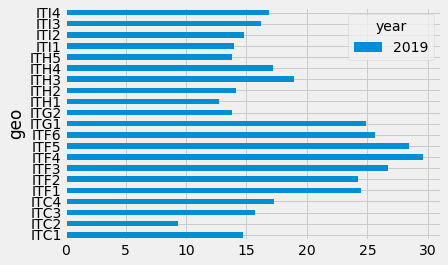

In [17]:
# Working on employment gap

pivoted2 = df2.pivot_table(index='geo', columns='year', values='values')
pivoted2.reset_index(inplace=True)

italy_gap = pivoted2[pivoted2['geo'].str.startswith('IT')][['geo','2019']]

#pivoted2[pivoted2['geo'].str.startswith(('IT','DE'))]


italy_gap.plot('geo', kind='barh')

## Map

We first select the projection that will be used in this exercise. For visualisation purpose, we select the common lat/lon coordinate system (WGS84, or EPSG:4326) as the reference system:

In [18]:
PROJ = 'EPSG:4326'

In [19]:
GISCO_DOMAIN = 'https://gisco-services.ec.europa.eu/distribution/v2/'
NUTS_DOMAIN = 'nuts'

NUTS_YEAR = 2016
NUTS_RES = 20 # 60
NUTS_PROJ = PROJ.split(':')[-1] 
NUTS_FMT = 'geojson' # 'topojson'

nuts_template = 'NUTS_RG_%sM_%s_%s_LEVL_%%s.%s' % (NUTS_RES, NUTS_YEAR, NUTS_PROJ, NUTS_FMT) 
nuts_url = '%s/%s/%s' %  (GISCO_DOMAIN, NUTS_DOMAIN, NUTS_FMT)

#https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_20M_2021_3857_LEVL_1.geojson
#    'NUTS_RG_%sM_%s_3035_LEVL_%s.%s'

print("Generic URL for NUTS data: \033[1m%s/%s\033[0m (where '%%s' represents a level)" 
      % (nuts_url, nuts_template))

Generic URL for NUTS data: https://gisco-services.ec.europa.eu/distribution/v2//nuts/geojson/NUTS_RG_20M_2016_4326_LEVL_%s.geojson (where '%s' represents a level)


In [20]:
LEVELS = [0,1,2
          #,3
         ]

nuts_files = dict.fromkeys(LEVELS)
nuts_ext = NUTS_FMT

for level in LEVELS:
    nuts_file = nuts_template % level
    nuts_source = '%s/%s' % (nuts_url,nuts_file)
    try : 
        dest = os.path.join(_THISDIR_[0], nuts_file)
        assert os.path.exists(dest)
    except:
        try:
            !wget -O $dest "$nuts_source"
            #!mkdir $nuts_dir
            #!unzip -u -d $nuts_dir $nuts_source        
        except:
            raise IOError("Error fetching the data...")
        else:
            print('Data loaded on disk in directory: \033[1m%s\033[0m' % dest)
    else:
        print('Data already loaded on disk in directory: \033[1m%s\033[0m' % dest)
    finally:
        nuts_files.update({level: nuts_file}) # dest

Data already loaded on disk in directory: /home/erico/git_workspace/istat_2020/NUTS_RG_20M_2016_4326_LEVL_0.geojson
Data already loaded on disk in directory: /home/erico/git_workspace/istat_2020/NUTS_RG_20M_2016_4326_LEVL_1.geojson
Data already loaded on disk in directory: /home/erico/git_workspace/istat_2020/NUTS_RG_20M_2016_4326_LEVL_2.geojson


#### Data Preparation

In [21]:
# We 'store' one vector dataset per NUTS level (nuts_data)

DRIVERS = {'geojson': 'GeoJSON',
          'shp': 'ESRI Shapefile'}

nuts_data = dict.fromkeys(LEVELS)
[nuts_data.update({l: gpd.read_file(os.path.join(_THISDIR_[0], nuts_files[l]), 
                                    driver=DRIVERS[NUTS_FMT])}) 
 for l in LEVELS]

print("Geographical datasets: \033[1m%s\033[0m loaded" % list(nuts_files.values()))
print("Projection: \033[1m%s\033[0m" % nuts_data[LEVELS[0]].crs)

nuts_data[LEVELS[0]].head(5)

Geographical datasets: ['NUTS_RG_20M_2016_4326_LEVL_0.geojson', 'NUTS_RG_20M_2016_4326_LEVL_1.geojson', 'NUTS_RG_20M_2016_4326_LEVL_2.geojson'] loaded
Projection: epsg:4326


id  COAST_TYPE  MOUNT_TYPE CNTR_CODE FID NUTS_ID        NUTS_NAME  \
0  ES           0           0        ES  ES      ES          ESPAÑA    
1  FI           0           0        FI  FI      FI  SUOMI / FINLAND   
2  IS           0           0        IS  IS      IS           ÍSLAND   
3  FR           0           0        FR  FR      FR           FRANCE   
4  HR           0           0        HR  HR      HR         HRVATSKA   

   LEVL_CODE  URBN_TYPE                                           geometry  
0          0          0  (POLYGON ((-7.03184 43.54447, -6.29214 43.5699...  
1          0          0  (POLYGON ((28.92968 69.0519, 28.62465 68.93047...  
2          0          0  POLYGON ((-22.0074 63.83599, -22.13087 63.8366...  
3          0          0  (POLYGON ((2.60704 50.91269, 2.64799 50.82501,...  
4          0          0  (POLYGON ((16.59681 46.4759, 16.85476 46.35044...

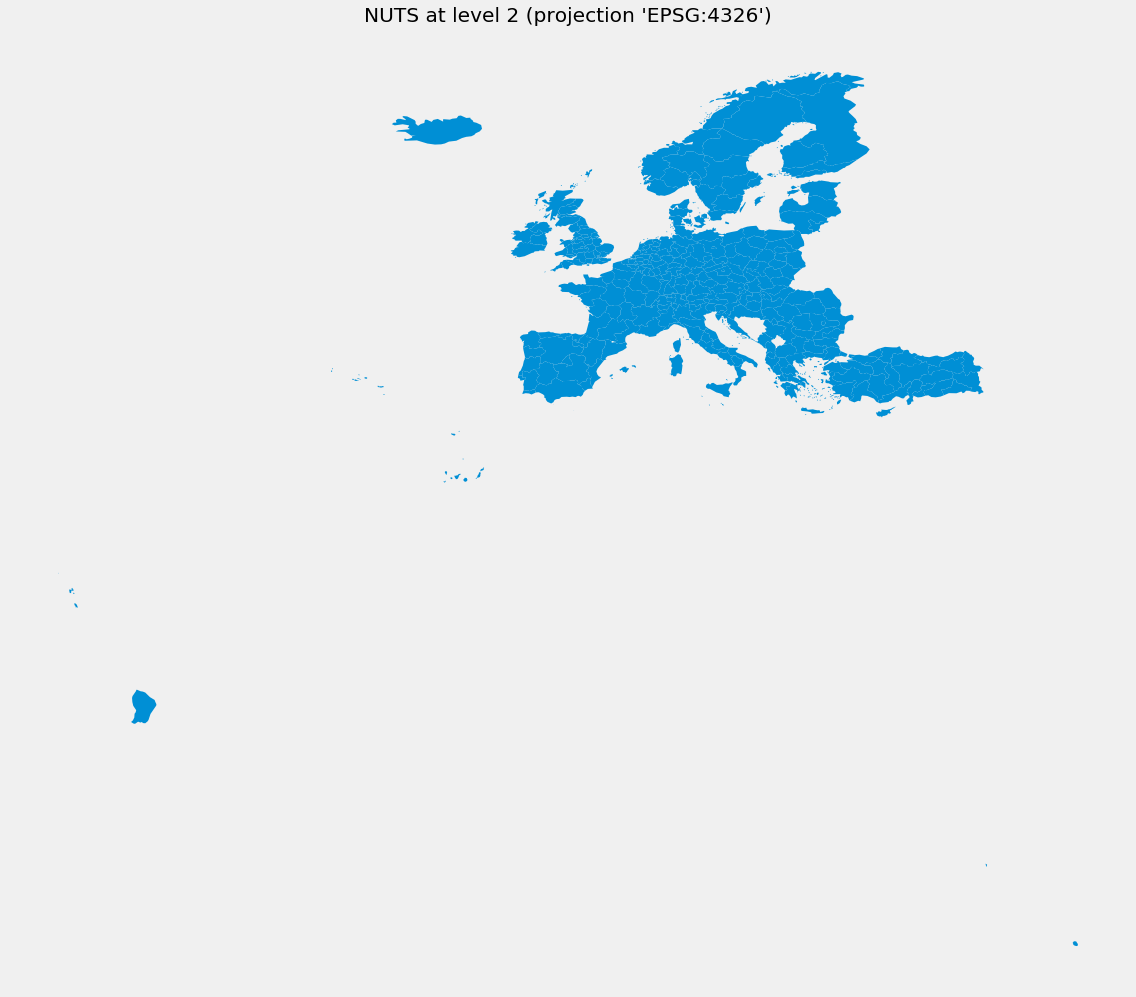

In [22]:
# Visualize the map without data

level = LEVELS[2]

f, ax = mplt.subplots(1, figsize=(16, 16))
nuts_data[level].plot(ax=ax)
ax.axes.get_xaxis().set_visible(False); ax.axes.get_yaxis().set_visible(False)
ax.set_title("NUTS at level %s (projection 'EPSG:%s')" % (level,NUTS_PROJ)) 
f.tight_layout()
mplt.show()

#### Data Exploration

We add the labor data

In [23]:
print(df.shape) #dimension
print(df2.shape)

(29051, 5)
(1352, 4)


In [24]:
# Select only member states:

pivo = pivo[pivo['NUTS_ID'].str.startswith(('AT','BE','BG','CY','CZ','DE','DK','EE','EL','ES','FI', 
                                            'FR','HR','HU','IE','IT','LT','LU','LV','MT', 'NL', 'PL',
                                            'PT', 'RO', 'SE', 'SI', 'SK'))]

In [25]:
KEY = 'NUTS_ID'

NUTS_ID = dict.fromkeys(LEVELS)
CTRY_ID = dict.fromkeys(LEVELS) 

for l in LEVELS:
    NUTS_ID.update({l: nuts_data[l][KEY].unique().tolist()})
    CTRY_ID.update({l: list(set([_id[:2] for _id in NUTS_ID[l]]))})
    
DATA_NUTS_ID = dict.fromkeys(LEVELS) 
all_id = pivo['NUTS_ID'].unique().tolist()

print('Data are availalble:') 
for l in LEVELS:
    DATA_NUTS_ID.update({l: list(set([_id[:2] for _id in all_id if len(_id)==l+2]))})
    print('* NUTS level %s: \033[1m%s\033[0m' 
          % (l, DATA_NUTS_ID[l]))

Data are availalble:
* NUTS level 0: ['CY', 'IT', 'SE', 'BE', 'HR', 'IE', 'PL', 'LV', 'MT', 'NL', 'FI', 'DK', 'EE', 'LU', 'SI', 'PT', 'CZ', 'RO', 'HU', 'AT', 'LT', 'ES', 'DE', 'BG', 'FR', 'EL', 'SK']
* NUTS level 1: ['CY', 'IT', 'SE', 'BE', 'HR', 'IE', 'PL', 'LV', 'MT', 'NL', 'FI', 'DK', 'EE', 'LU', 'SI', 'PT', 'CZ', 'RO', 'HU', 'AT', 'LT', 'ES', 'DE', 'BG', 'FR', 'EL', 'SK']
* NUTS level 2: ['CY', 'IT', 'SE', 'BE', 'HR', 'IE', 'PL', 'LV', 'MT', 'NL', 'FI', 'DK', 'EE', 'LU', 'SI', 'PT', 'CZ', 'RO', 'HU', 'AT', 'LT', 'ES', 'DE', 'BG', 'FR', 'EL', 'SK']


We can see for any given level, which country/datasets are missing:

In [26]:
MISSING_CTRY_ID = dict.fromkeys(LEVELS) 

print('Data are NOT availalble:') 
for l in LEVELS:
    MISSING_CTRY_ID.update({l: list(set(CTRY_ID[l]).difference(set(DATA_NUTS_ID[l])))})
    print('* NUTS level %s: \033[1m%s\033[0m' 
          % (l, MISSING_CTRY_ID[l]))

Data are NOT availalble:
* NUTS level 0: ['RS', 'TR', 'LI', 'CH', 'IS', 'NO', 'AL', 'ME', 'MK', 'UK']
* NUTS level 1: ['RS', 'TR', 'LI', 'CH', 'IS', 'NO', 'AL', 'ME', 'MK', 'UK']
* NUTS level 2: ['RS', 'TR', 'LI', 'CH', 'IS', 'NO', 'AL', 'ME', 'MK', 'UK']


Build table

In [27]:
pivo

year NUTS_ID sex wstatus      2010      2013      2016      2019
0         AT   F     ACT  0.719394  0.737195  0.748250  0.756105
1         AT   F     EMP  0.688398  0.700441  0.708694  0.724138
2         AT   F    INAC  0.280606  0.262766  0.251787  0.243932
3         AT   F     POP  1.000000  1.000000  1.000000  1.000000
4         AT   F     UNE  0.030996  0.036793  0.039557  0.031967
5         AT   M     ACT  0.830367  0.835151  0.839958  0.849326
6         AT   M     EMP  0.790421  0.791367  0.787447  0.811722
7         AT   M    INAC  0.169633  0.164849  0.160079  0.150637
8         AT   M     POP  1.000000  1.000000  1.000000  1.000000
9         AT   M     UNE  0.039946  0.043784  0.052474  0.037604
10        AT   T     ACT  0.774519  0.785888  0.794068  0.802684
11        AT   T     EMP  0.739077  0.745639  0.748054  0.767901
12        AT   T    INAC  0.225481  0.214112  0.205932  0.197316
13        AT   T     POP  1.000000  1.000000  1.000000  1.000000
14        AT   T     UNE  0.035442  0.040268  0.046014  0.034783
15       AT1   F     ACT  0.714479  0.732436  0.738292  0.742723
16       AT1   F     EMP  0.677899  0.685483  0.687123  0.698896
17       AT1   F    INAC  0.285521  0.267564  0.261708  0.257193
18       AT1   F     POP  1.000000  1.000000  1.000000  1.000000
19       AT1   F     UNE  0.036580  0.046865  0.051169  0.043827
20       AT1   M     ACT  0.822645  0.821756  0.826835  0.841771
21       AT1   M     EMP  0.770324  0.764891  0.753335  0.784287
22       AT1   M    INAC  0.177355  0.178244  0.173165  0.158229
23       AT1   M     POP  1.000000  1.000000  1.000000  1.000000
24       AT1   M     UNE  0.052321  0.056775  0.073500  0.057484
25       AT1   T     ACT  0.767961  0.776538  0.782244  0.791989
26       AT1   T     EMP  0.723559  0.724774  0.720022  0.741333
27       AT1   T    INAC  0.232039  0.223462  0.217713  0.208011
28       AT1   T     POP  1.000000  1.000000  1.000000  1.000000
29       AT1   T     UNE  0.044402  0.051763  0.062265  0.050614
...      ...  ..     ...       ...       ...       ...       ...
5974    SK03   F     ACT  0.654562  0.674081  0.694611  0.714557
5975    SK03   F     EMP  0.548570  0.568543  0.618148  0.671882
5976    SK03   F    INAC  0.345438  0.325919  0.305389  0.285443
5977    SK03   F     POP  1.000000  1.000000  1.000000  1.000000
5978    SK03   F     UNE  0.105765  0.105538  0.076462  0.042674
5979    SK03   M     ACT  0.823236  0.836932  0.846642  0.840909
5980    SK03   M     EMP  0.693442  0.695682  0.759074  0.790121
5981    SK03   M    INAC  0.176764  0.162843  0.153358  0.158859
5982    SK03   M     POP  1.000000  1.000000  1.000000  1.000000
5983    SK03   M     UNE  0.130020  0.141251  0.087568  0.050788
5984    SK03   T     ACT  0.738908  0.755960  0.771200  0.778429
5985    SK03   T     EMP  0.621014  0.632584  0.689143  0.731536
5986    SK03   T    INAC  0.261092  0.244040  0.228686  0.221571
5987    SK03   T     POP  1.000000  1.000000  1.000000  1.000000
5988    SK03   T     UNE  0.117894  0.123376  0.082057  0.046776
5989    SK04   F     ACT  0.644108  0.645976  0.657480  0.675600
5990    SK04   F     EMP  0.529260  0.528490  0.560630  0.612200
5991    SK04   F    INAC  0.355892  0.354024  0.342520  0.324200
5992    SK04   F     POP  1.000000  1.000000  1.000000  1.000000
5993    SK04   F     UNE  0.114849  0.117682  0.096850  0.063400
5994    SK04   M     ACT  0.826877  0.828146  0.820325  0.831285
5995    SK04   M     EMP  0.676917  0.680456  0.728555  0.764970
5996    SK04   M    INAC  0.173123  0.172047  0.179482  0.168715
5997    SK04   M     POP  1.000000  1.000000  1.000000  1.000000
5998    SK04   M     UNE  0.150160  0.147690  0.091770  0.066316
5999    SK04   T     ACT  0.735347  0.737574  0.739665  0.754419
6000    SK04   T     EMP  0.602970  0.604805  0.645476  0.689543
6001    SK04   T    INAC  0.264653  0.262329  0.260238  0.245482
6002    SK04   T     POP  1.000000  1.000000  1.000000  1.000000
6003    SK04   T     UNE  0.132376 

In [28]:
def build_table(pivo, year = '2019', key='NUTS_ID', wstatus = "EMP", sex = "T", miss_id = {}):
    try:
        assert isinstance(pivo, (pd.Series,pd.DataFrame))
    except:
        raise IOError('wrong format for input dataset')
    col_drop = list(set(pivo.columns).difference(set(['NUTS_ID',year])))
    data_miss = pd.DataFrame({key: miss_id[0].copy(), year: np.nan})
    return pd.concat([(
        pivo.loc[(pivo["wstatus"]==wstatus) & (pivo["sex"]==sex)]
        .copy()
        .drop(columns=col_drop)
        #.dropna(axis='index', subset=[year])
        .rename(columns={'geo':key})
        ),
        data_miss
        ], 
        axis=0, ignore_index=True
    )

total = build_table(pivo, year = '2019', key=KEY, 
                           wstatus = 'EMP', sex = 'T', 
                           miss_id=MISSING_CTRY_ID)

total.head(-10)

year NUTS_ID      2019
0         AT  0.767901
1        AT1  0.741333
2       AT11  0.753714
3       AT12  0.784545
4       AT13  0.703525
5        AT2  0.766985
6       AT21  0.750527
7       AT22  0.774211
8        AT3  0.800992
9       AT31  0.802630
10      AT32  0.804748
11      AT33  0.796073
12      AT34  0.799077
13        BE  0.704977
14       BE1  0.616807
15      BE10  0.616807
16       BE2  0.754503
17      BE21  0.743604
18      BE22  0.724272
19      BE23  0.764958
20      BE24  0.761439
21      BE25  0.774456
22       BE3  0.646294
23      BE31  0.714470
24      BE32  0.609210
25      BE33  0.642590
26      BE34  0.711031
27      BE35  0.661688
28        BG  0.750108
29       BG3  0.720016
..       ...       ...
333     RO21  0.794933
334     RO22  0.654104
335      RO3  0.729248
336     RO31  0.699856
337     RO32  0.763147
338      RO4  0.670969
339     RO41  0.689688
340     RO42  0.651418
341       SE  0.821141
342      SE1  0.831122
343     SE11  0.849078
344     SE12  0.804855
345      SE2  0.817745
346     SE21  0.841484
347     SE22  0.781899
348     SE23  0.834567
349      SE3  0.805324
350     SE31  0.800634
351     SE32  0.809732
352     SE33  0.810247
353       SI  0.764444
354      SI0  0.764444
355     SI03  0.748085
356     SI04  0.782572
357       SK  0.733994
358      SK0  0.733994
359     SK01  0.813333
360     SK02  0.746149
361     SK03  0.731536
362     SK04  0.689543

[363 rows x 2 columns]

In [29]:
#keeping = ['NUTS_ID', 'sex', 'wstatus', '2019']

#total = pivo[(pivo['sex']=='T') & (pivo['wstatus']=='EMP')]
#total = total[keeping]

#females = pivo[(pivo['sex']=='F') & (pivo['wstatus']=='EMP')]
#females = females[keeping]

#males = pivo[(pivo['sex']=='M') & (pivo['wstatus']=='EMP')]
#males = males[keeping]

In [30]:
def build_unit_level(nuts, labor, levels = [0, 1, 2], key='NUTS_ID', how='inner'): 
    try:
        assert (isinstance(nuts, dict) 
                and all([isinstance(pivo,(gpd.GeoSeries, gpd.GeoDataFrame)) for pivo in nuts.values()])
                and set(nuts.keys()).difference(set(levels)) == set())
    except:
        raise IOError('wrong format for input data dictionary')
    data = dict.fromkeys(levels)
    for l in levels:
        temp = (nuts[l]
                .merge(labor, on=key, how=how)
               )
        temp = temp[~(temp.geometry.is_empty | temp.geometry.isna())]
        temp.geometry = temp.geometry.buffer(0) # deal with invalid geometry
        data.update({l: temp})
    return data

total_data = build_unit_level(nuts_data, total, 
                                   levels = LEVELS, key = KEY, how='right') 

total_data[2].head()

id  COAST_TYPE  MOUNT_TYPE CNTR_CODE   FID NUTS_ID      NUTS_NAME  \
0  CY00         0.0         0.0        CY  CY00    CY00         Κύπρος   
1  CZ01         0.0         0.0        CZ  CZ01    CZ01          Praha   
2  CZ02         0.0         0.0        CZ  CZ02    CZ02  Střední Čechy   
3  CZ03         0.0         0.0        CZ  CZ03    CZ03      Jihozápad   
4  CZ04         0.0         0.0        CZ  CZ04    CZ04    Severozápad   

   LEVL_CODE  URBN_TYPE                                           geometry  \
0        2.0        0.0  POLYGON ((32.27382 35.06649, 32.28884 35.10503...   
1        2.0        0.0  POLYGON ((14.27179 50.09796, 14.30331 50.12882...   
2        2.0        0.0  POLYGON ((15.14677 50.52294, 15.13609 50.46398...   
3        2.0        0.0  POLYGON ((13.40705 50.08962, 13.80018 49.91814...   
4        2.0        0.0  POLYGON ((14.48649 50.50503, 14.37508 50.39708...   

       2019  
0  0.757043  
1  0.837396  
2  0.827032  
3  0.806416  
4  0.775663

In [31]:
def propagate_unit_level(data, levels = [0, 1, 2], year = '2019', key = 'NUTS_ID', miss_id = {}):
    try:
        assert (isinstance(data, dict) 
                and all([isinstance(pivo,(gpd.GeoSeries, gpd.GeoDataFrame)) for pivo in data.values()])
                and set(data.keys()).difference(set(levels)) == set())
    except:
        raise IOError('wrong format for input data dictionary')
    nan_ctry_id = copy.deepcopy(miss_id) or dict.fromkeys(levels) 
    for l in range(len(levels)):
        level = levels[l]
        nan_ctry_id[l].extend([_id[:2] 
                               for _id in data[level].loc[data[level][year].isnull(), key].unique().tolist() 
                               if len(_id)==l+2])
        nan_ctry_id[l] = list(set(nan_ctry_id[l]))
    for ctry in nan_ctry_id[0]:
        level0 = levels[0]
        data_miss = data[level0][data[level0][key].str.startswith(ctry)].copy()
        data_miss.geometry = data_miss.geometry.buffer(0)
        for level in levels[1:]:
            data[level] = pd.concat([data[level].loc[~(data[level][key].str.startswith(ctry))], 
                                     data_miss
                                    ], 
                                    axis=0, ignore_index=True
                                   )
    for l in range(1,len(levels)):
        for ctry in nan_ctry_id[l]:
            if ctry in nan_ctry_id[l-1]:
                continue
            levelp = levels[l-1]
            data_miss = data[levelp].loc[data[levelp][key].str.startswith(ctry)].copy()
            data_miss.geometry = data_miss.geometry.buffer(0)
            for l_ in range(l,len(levels)):
                level_ = levels[l_]
                data[level_] = pd.concat([data[level_].loc[~(data[level_][key].str.startswith(ctry))], 
                                          data_miss 
                                         ], 
                                         axis=0, ignore_index=True
                                        )
    return data

total_data = propagate_unit_level(total_data, miss_id = MISSING_CTRY_ID,
                                       levels = LEVELS, year = '2019', key = KEY)
total_data[2].head()

id  COAST_TYPE  MOUNT_TYPE CNTR_CODE   FID NUTS_ID      NUTS_NAME  \
0  CY00         0.0         0.0        CY  CY00    CY00         Κύπρος   
1  CZ01         0.0         0.0        CZ  CZ01    CZ01          Praha   
2  CZ02         0.0         0.0        CZ  CZ02    CZ02  Střední Čechy   
3  CZ03         0.0         0.0        CZ  CZ03    CZ03      Jihozápad   
4  CZ04         0.0         0.0        CZ  CZ04    CZ04    Severozápad   

   LEVL_CODE  URBN_TYPE                                           geometry  \
0        2.0        0.0  POLYGON ((32.27382 35.06649, 32.28884 35.10503...   
1        2.0        0.0  POLYGON ((14.27179 50.09796, 14.30331 50.12882...   
2        2.0        0.0  POLYGON ((15.14677 50.52294, 15.13609 50.46398...   
3        2.0        0.0  POLYGON ((13.40705 50.08962, 13.80018 49.91814...   
4        2.0        0.0  POLYGON ((14.48649 50.50503, 14.37508 50.39708...   

       2019  
0  0.757043  
1  0.837396  
2  0.827032  
3  0.806416  
4  0.775663

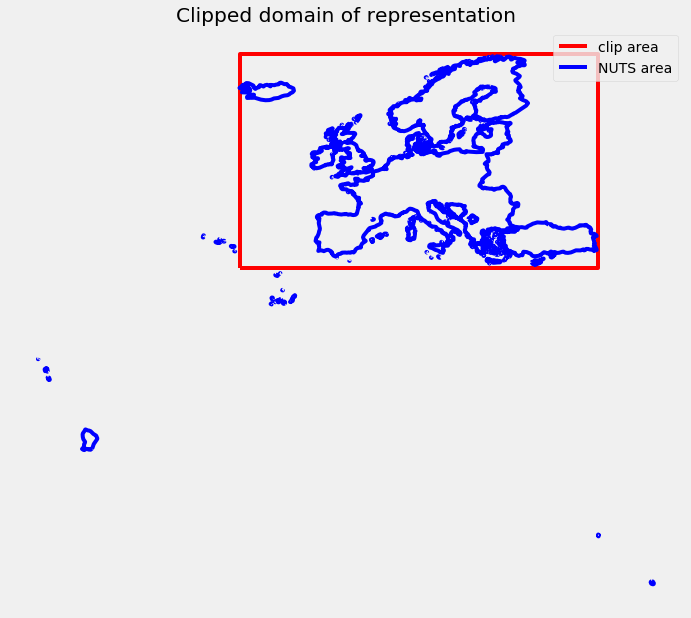

In [32]:
EUmask = geometry.Polygon([#w: -25.5, s:35, e:30.2, n:71.3 in EPSG:4326 system
                         (-24, 34),
                         (45, 34),
                         (45,  71.5),
                         (-24, 71.5)
])
EUclip = gpd.GeoDataFrame(index=[0], geometry=[EUmask], crs=PROJ)

NUTSarea = gpd.GeoDataFrame(index=[0], geometry=[nuts_data[0].unary_union], crs=PROJ)


f, ax = mplt.subplots(1, figsize=(16, 10))
EUclip.boundary.plot(ax=ax, color='r', label='clip area')
NUTSarea.boundary.plot(ax=ax, color='b', label='NUTS area')
ax.axes.get_xaxis().set_visible(False); ax.axes.get_yaxis().set_visible(False)
ax.set_title('Clipped domain of representation')
ax.legend()
mplt.show()

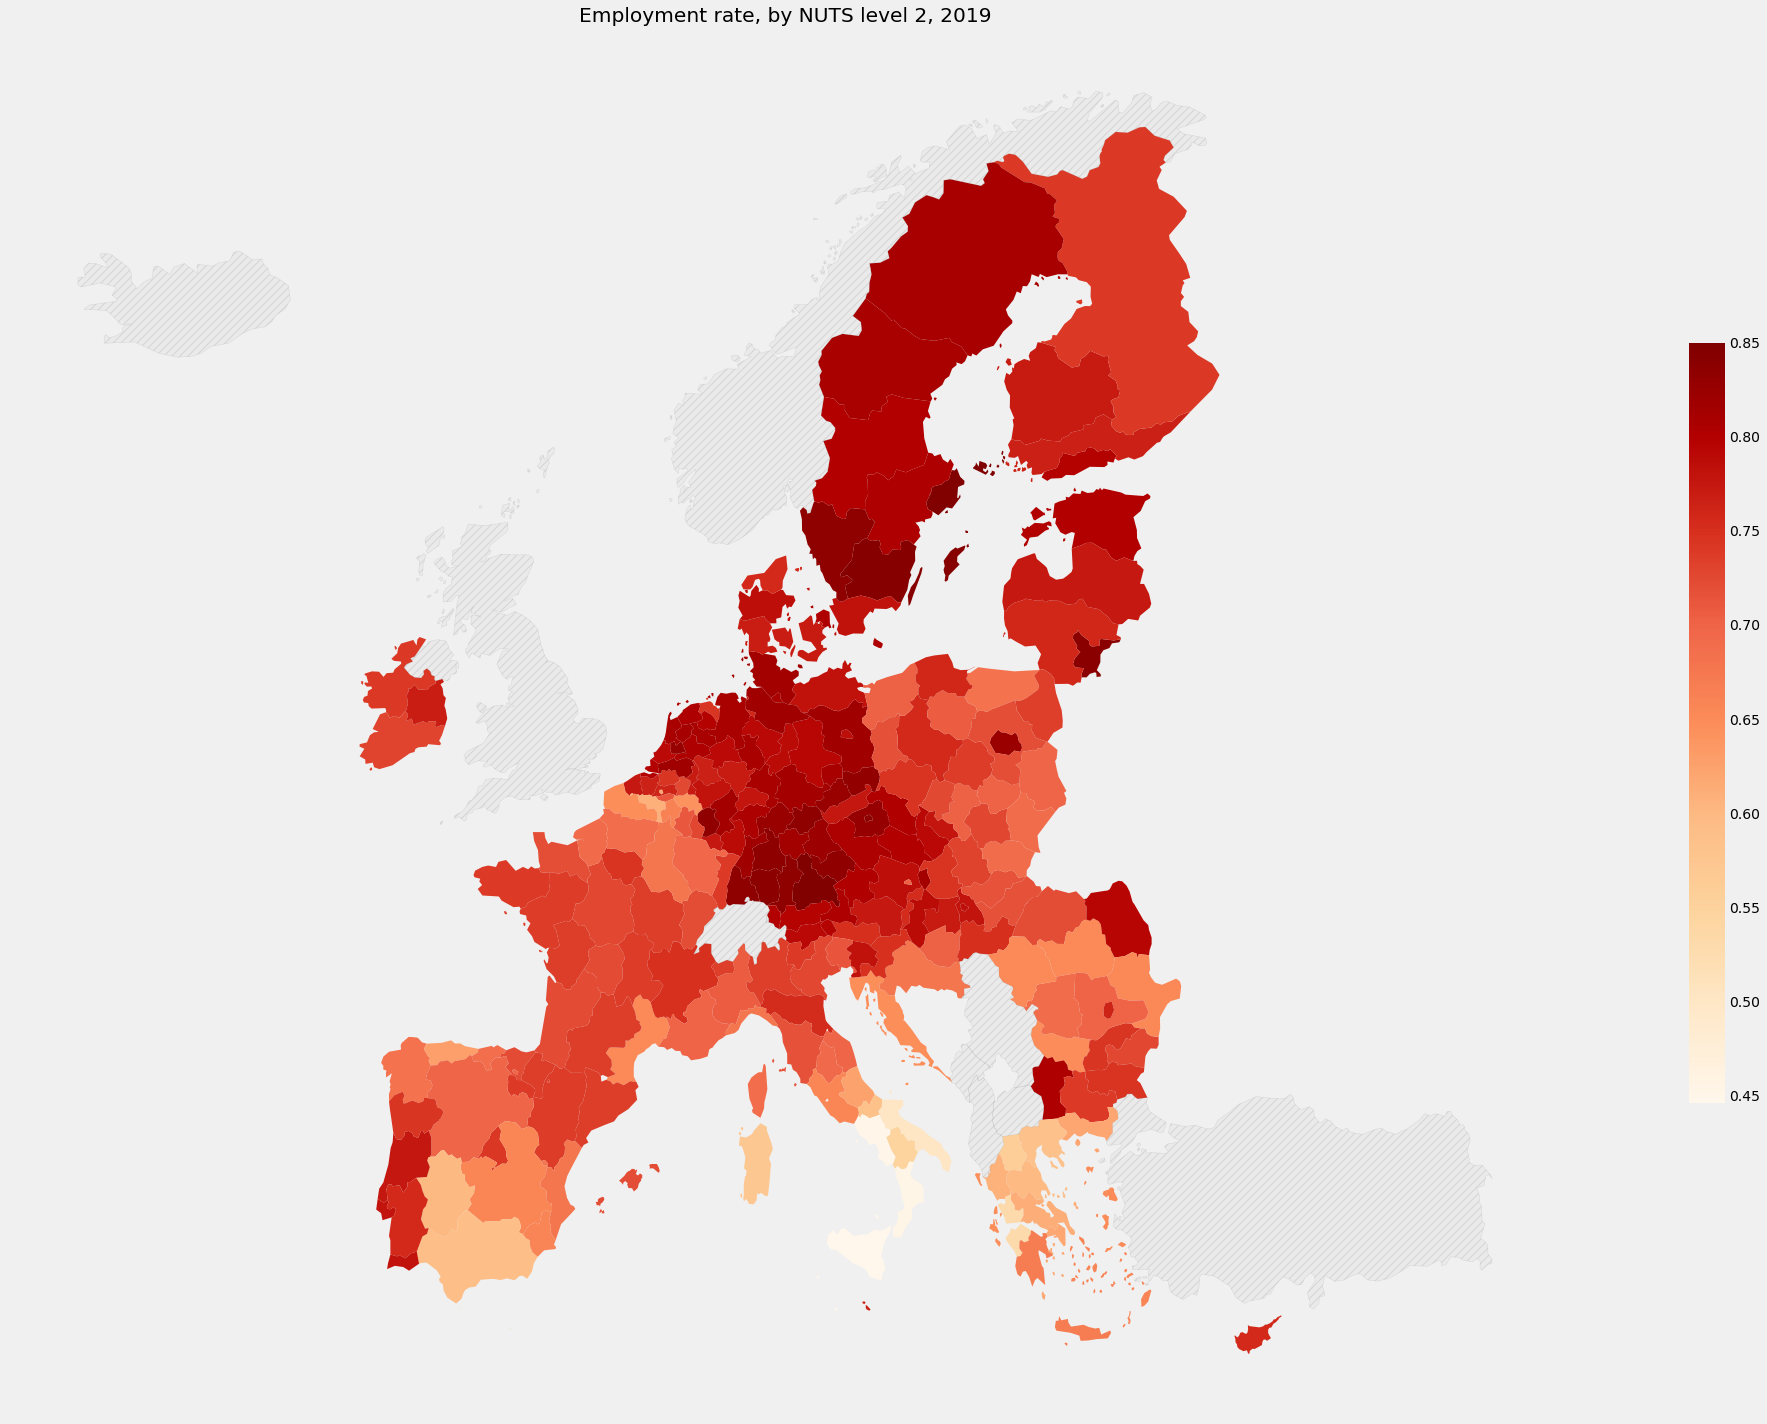

In [33]:
LEVEL = 2
YEAR = '2019'
crop = gpd.clip(total_data[LEVEL], EUclip)
# crop = nuts_death_data[LEVEL].intersection(EUclip.unary_union) 

f, ax = mplt.subplots(1, figsize=(35, 20))
crop.plot(column='2019', ax=ax, cmap='OrRd', legend=True,
          legend_kwds = {'shrink':0.55},
          missing_kwds={ "color": "lightgrey", "alpha": 0.2, "edgecolor": "grey", "hatch": "///"}
         )
ax.set_axis_off()
ax.set_title('Employment rate, by NUTS level %s, %s'
             % (LEVEL, YEAR))
f.tight_layout()
f.subplots_adjust(hspace=0,wspace=-1)
mplt.show()

### Temporal Visualization

In [34]:
YEARS

['2010', '2013', '2016', '2019']

In [35]:
DATERES, WEEKRES = None, list(range(9,18)) # select what you are interested
if WEEKRES is None:
    try:
        WEEKRES = DATERES.isocalendar()[1]
    except:
        WEEKRES = [15]
        
enumerate(WEEKRES)

In [36]:
SEX = list(['T','F','M'])
YEARS = list(['2010', '2013', '2016', '2019'])
WSTATUS = list(['EMP','UNE','INAC'])

lst=[]

for s in SEX:
    for w in WSTATUS:
        for y in YEARS:
            x = 'data_%s_%s_%s' %(s, w, y)
            lst.append(x)
            
lst

['data_T_EMP_2010',
 'data_T_EMP_2013',
 'data_T_EMP_2016',
 'data_T_EMP_2019',
 'data_T_UNE_2010',
 'data_T_UNE_2013',
 'data_T_UNE_2016',
 'data_T_UNE_2019',
 'data_T_INAC_2010',
 'data_T_INAC_2013',
 'data_T_INAC_2016',
 'data_T_INAC_2019',
 'data_F_EMP_2010',
 'data_F_EMP_2013',
 'data_F_EMP_2016',
 'data_F_EMP_2019',
 'data_F_UNE_2010',
 'data_F_UNE_2013',
 'data_F_UNE_2016',
 'data_F_UNE_2019',
 'data_F_INAC_2010',
 'data_F_INAC_2013',
 'data_F_INAC_2016',
 'data_F_INAC_2019',
 'data_M_EMP_2010',
 'data_M_EMP_2013',
 'data_M_EMP_2016',
 'data_M_EMP_2019',
 'data_M_UNE_2010',
 'data_M_UNE_2013',
 'data_M_UNE_2016',
 'data_M_UNE_2019',
 'data_M_INAC_2010',
 'data_M_INAC_2013',
 'data_M_INAC_2016',
 'data_M_INAC_2019']

In [37]:
temp_lst = list(['employment rate','unemployment ratio','inactivity rate'])
status = dict(zip(WSTATUS, temp_lst))

temp_lst = list(['RdYlGn',
                 'Spectral_r',
                 'RdYlBu_r'])
colors = dict(zip(WSTATUS, temp_lst))

temp_lst = list([0.9,
                 0.25,
                 0.6])
vmax = dict(zip(WSTATUS, temp_lst))

temp_lst = list([0.5,
                 0.05,
                 0.15])
vmin = dict(zip(WSTATUS, temp_lst))

temp_lst = list([8,
                 8,
                 6])
slices = dict(zip(WSTATUS, temp_lst))



temp_lst = list(['Total','Female','Male'])
gender = dict(zip(SEX, temp_lst))



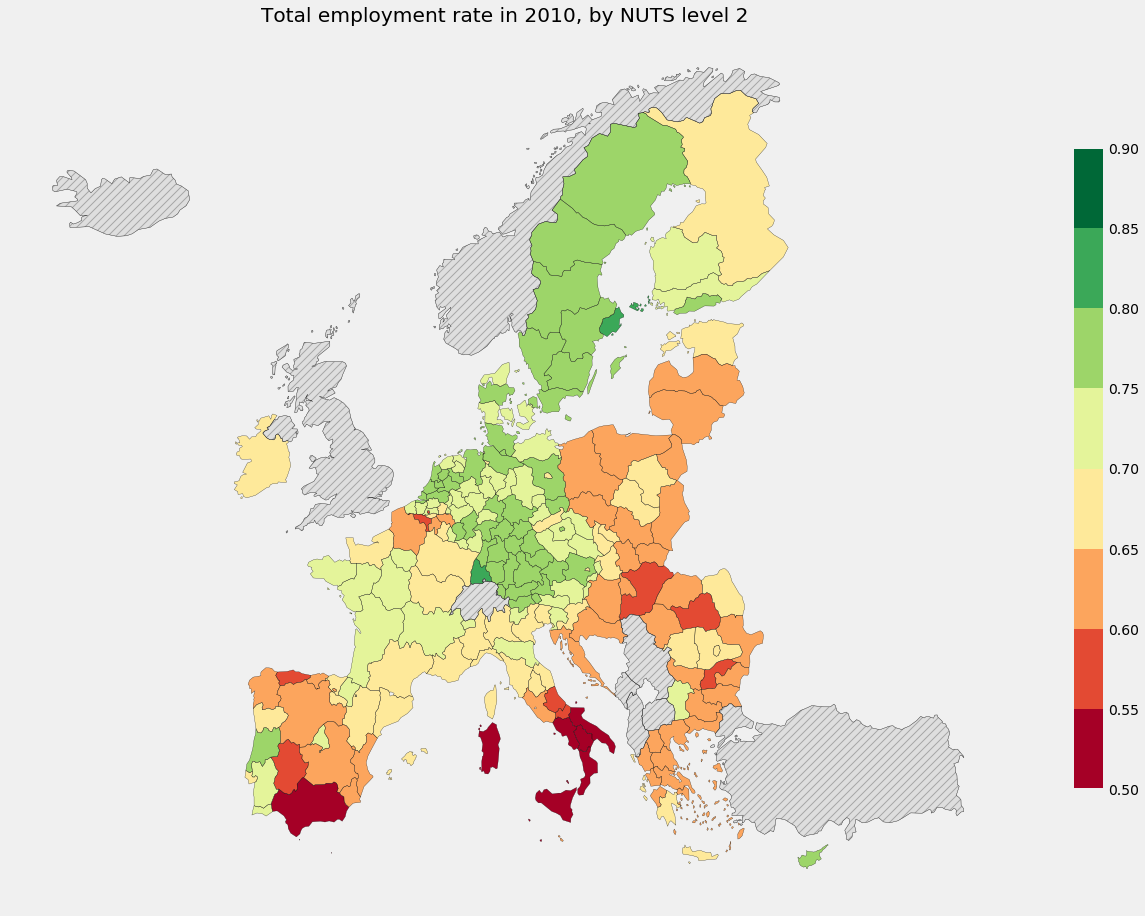

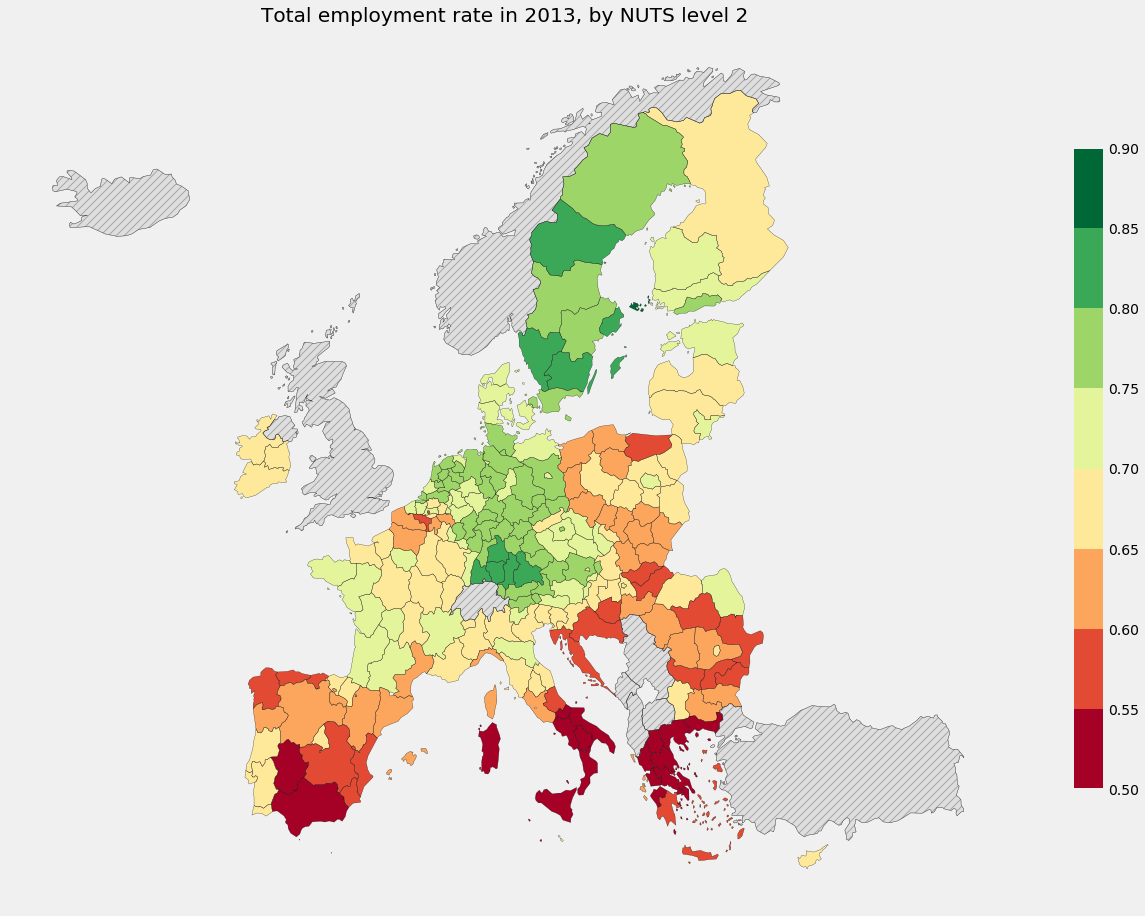

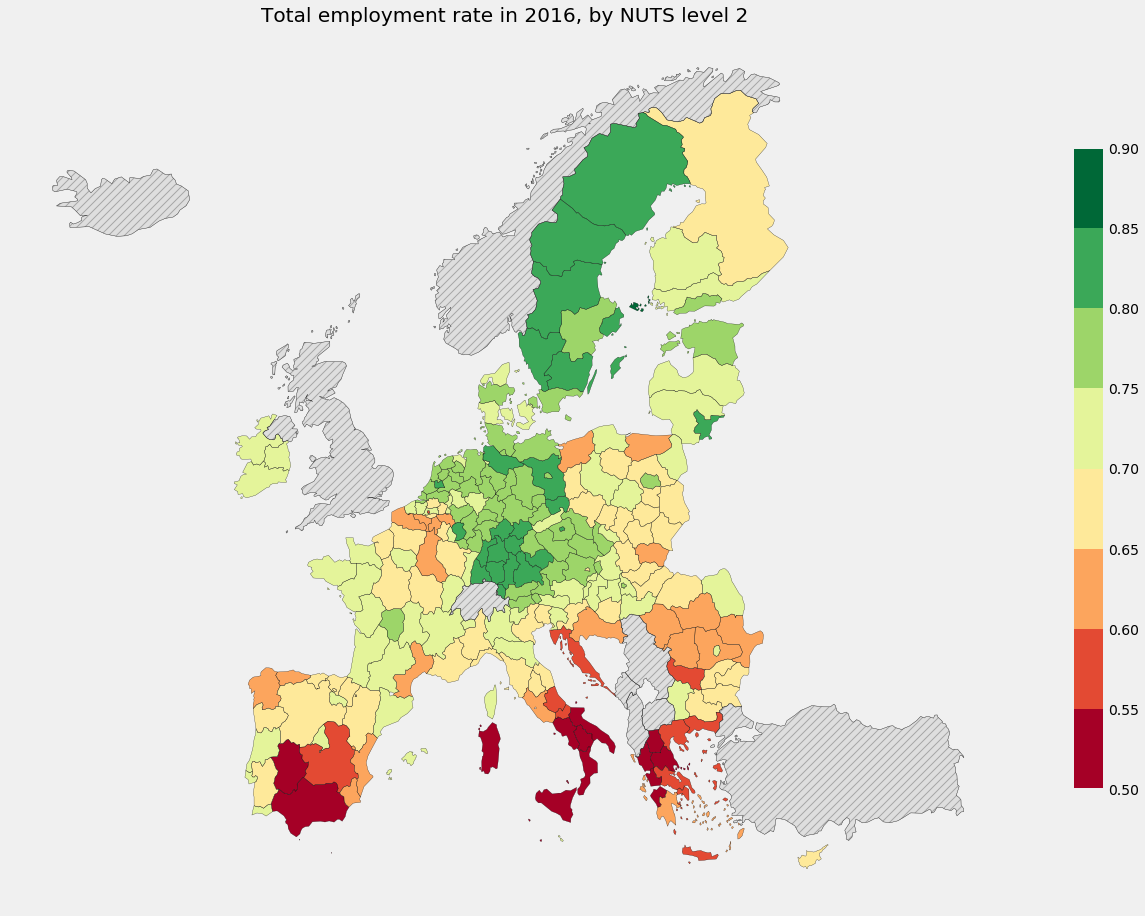

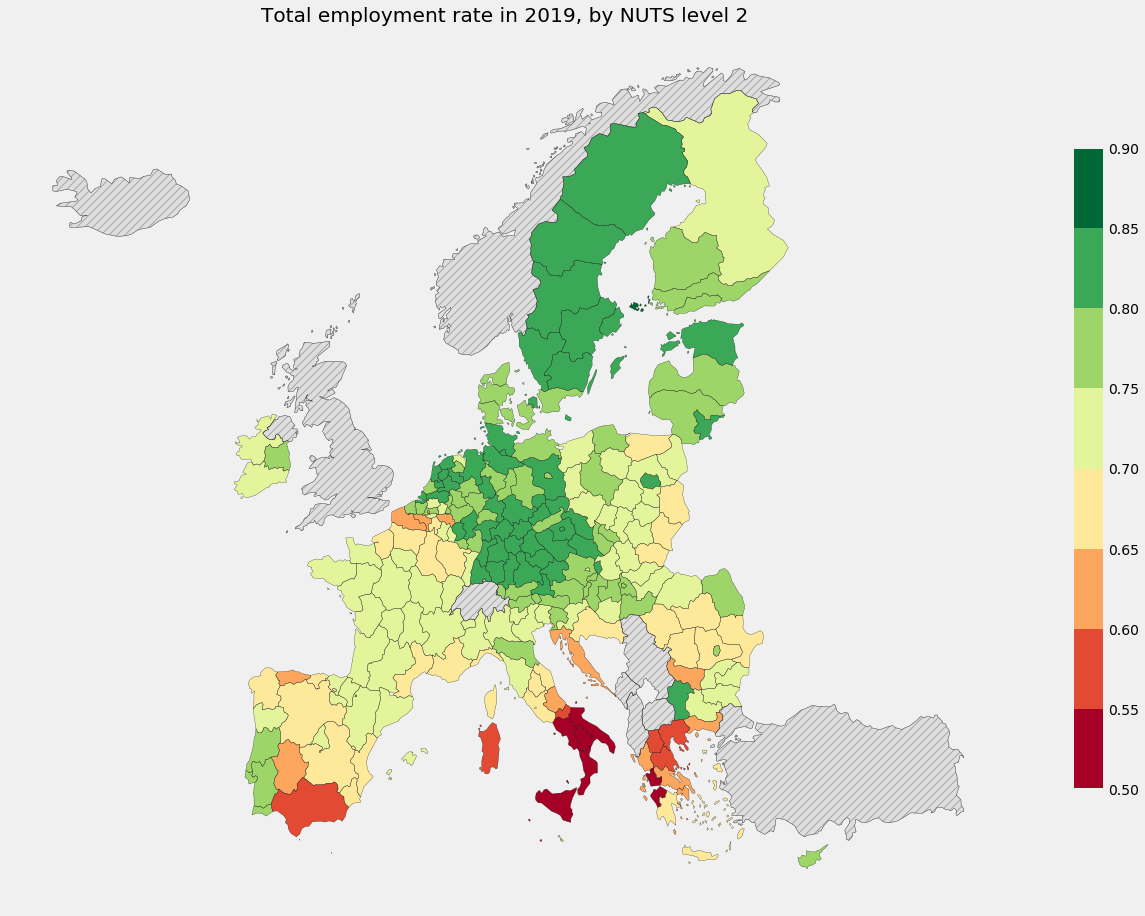

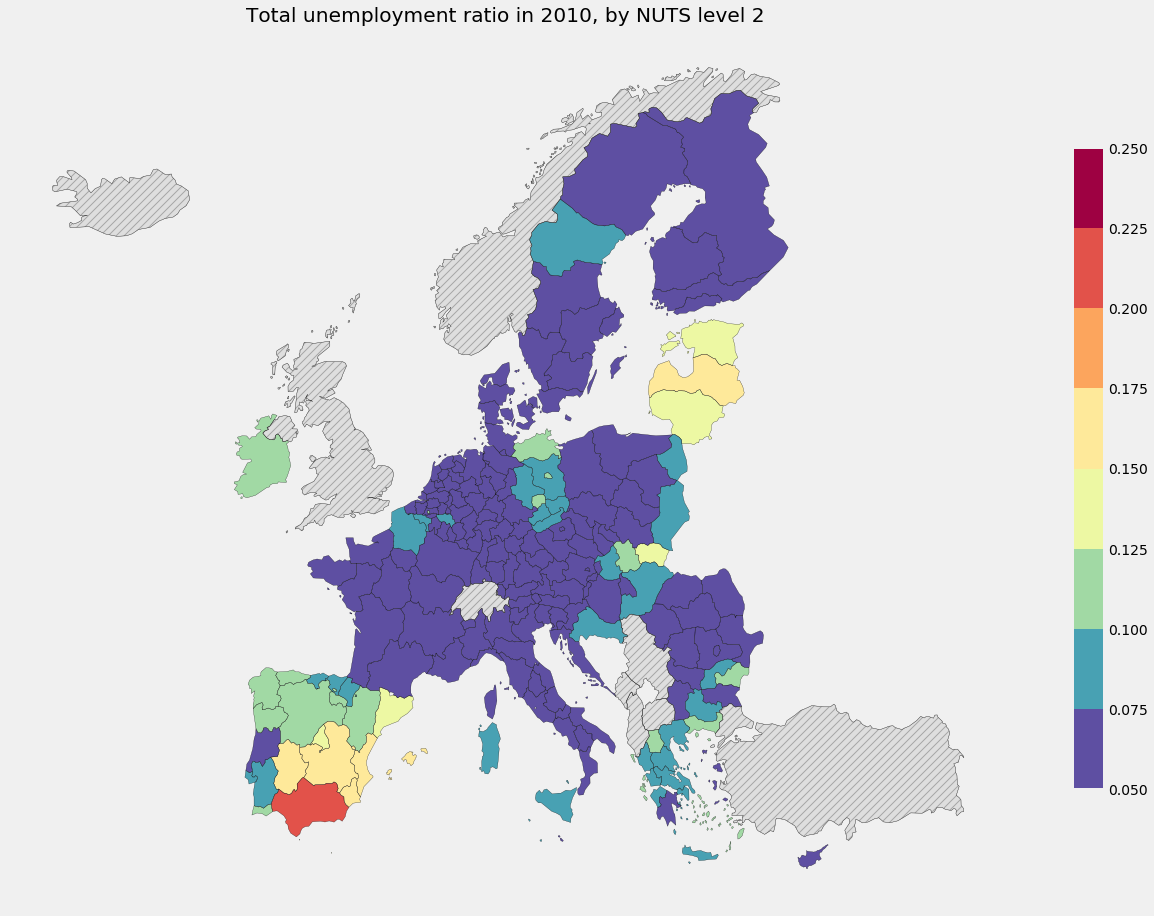

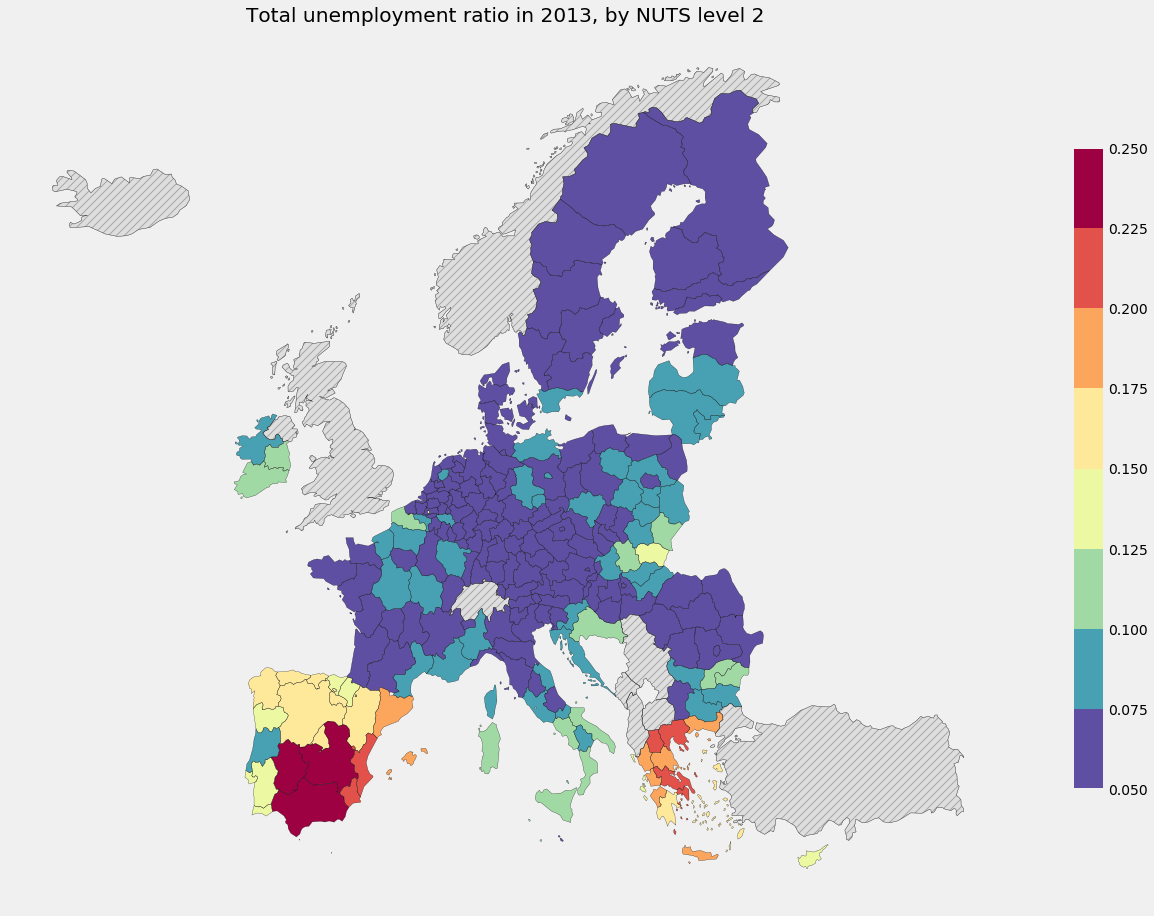

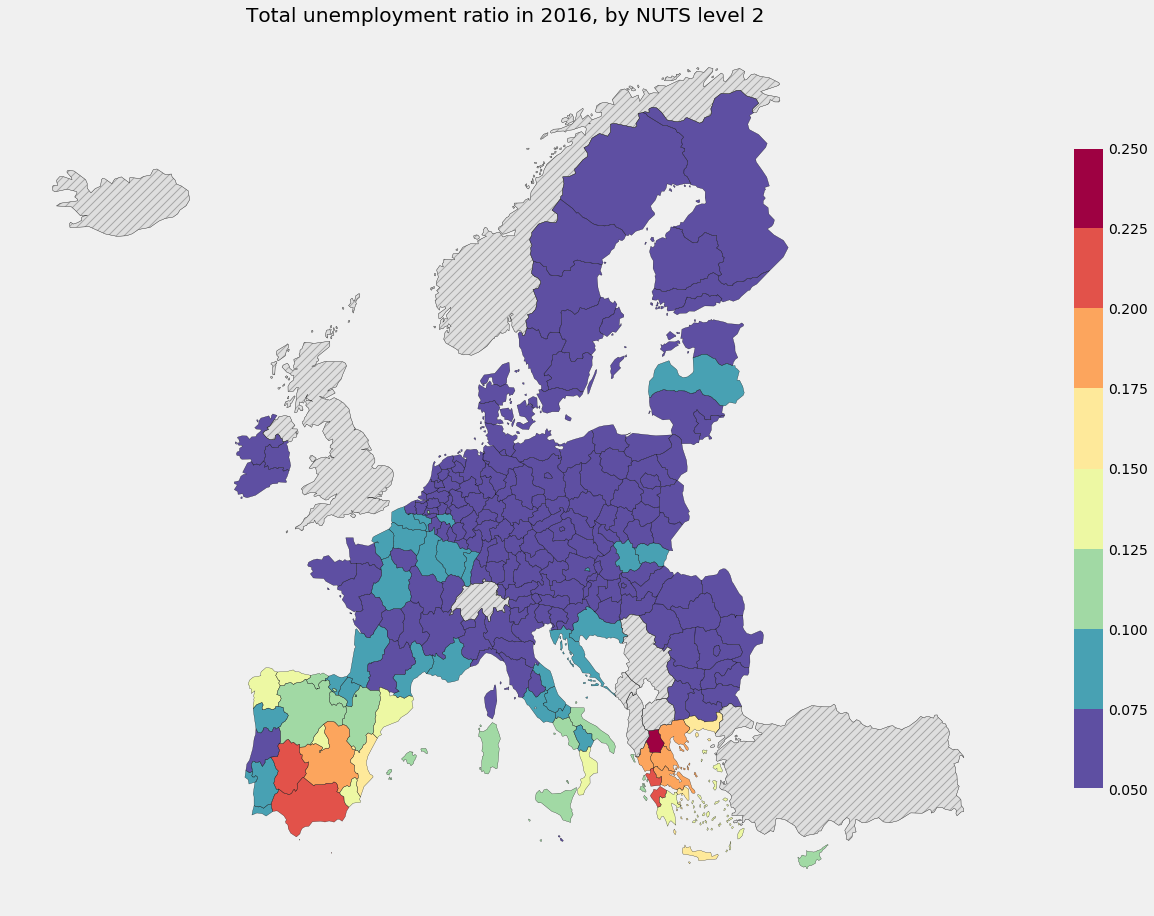

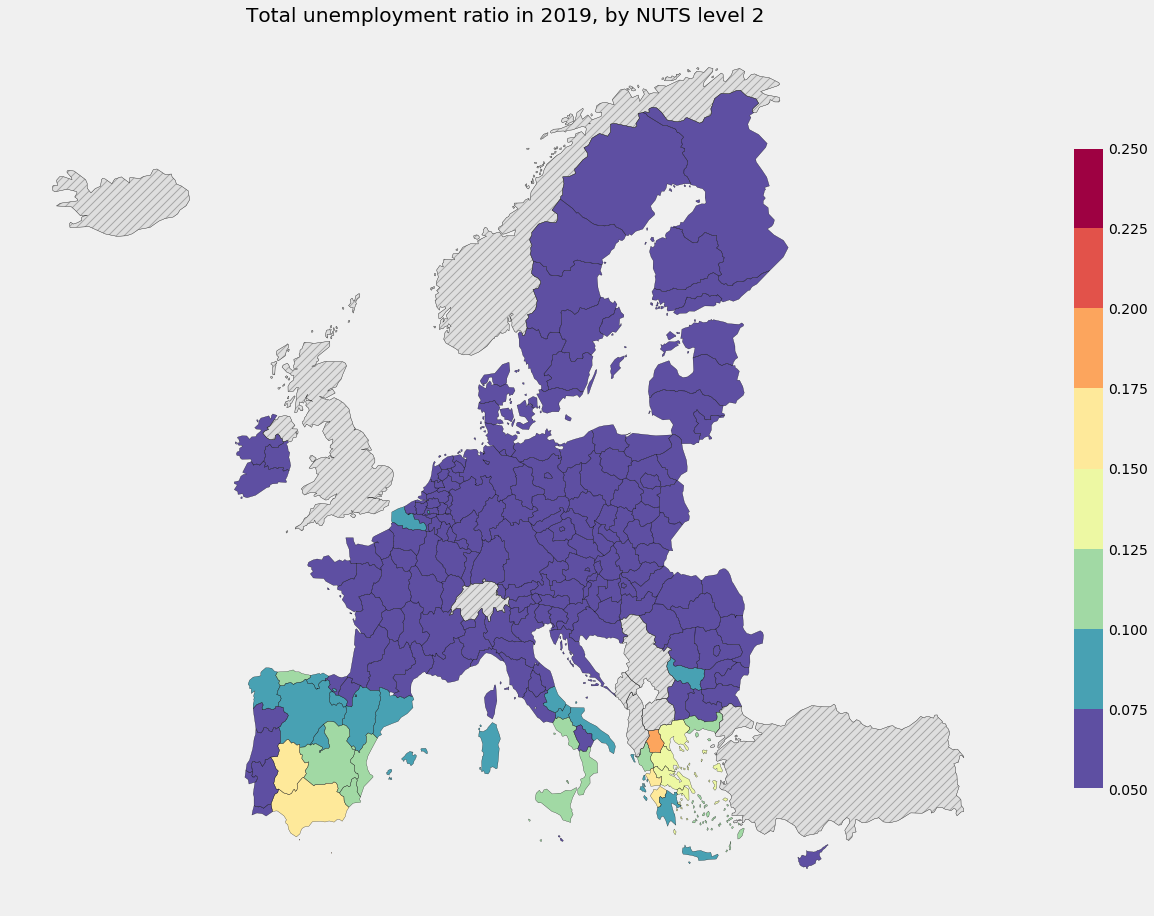

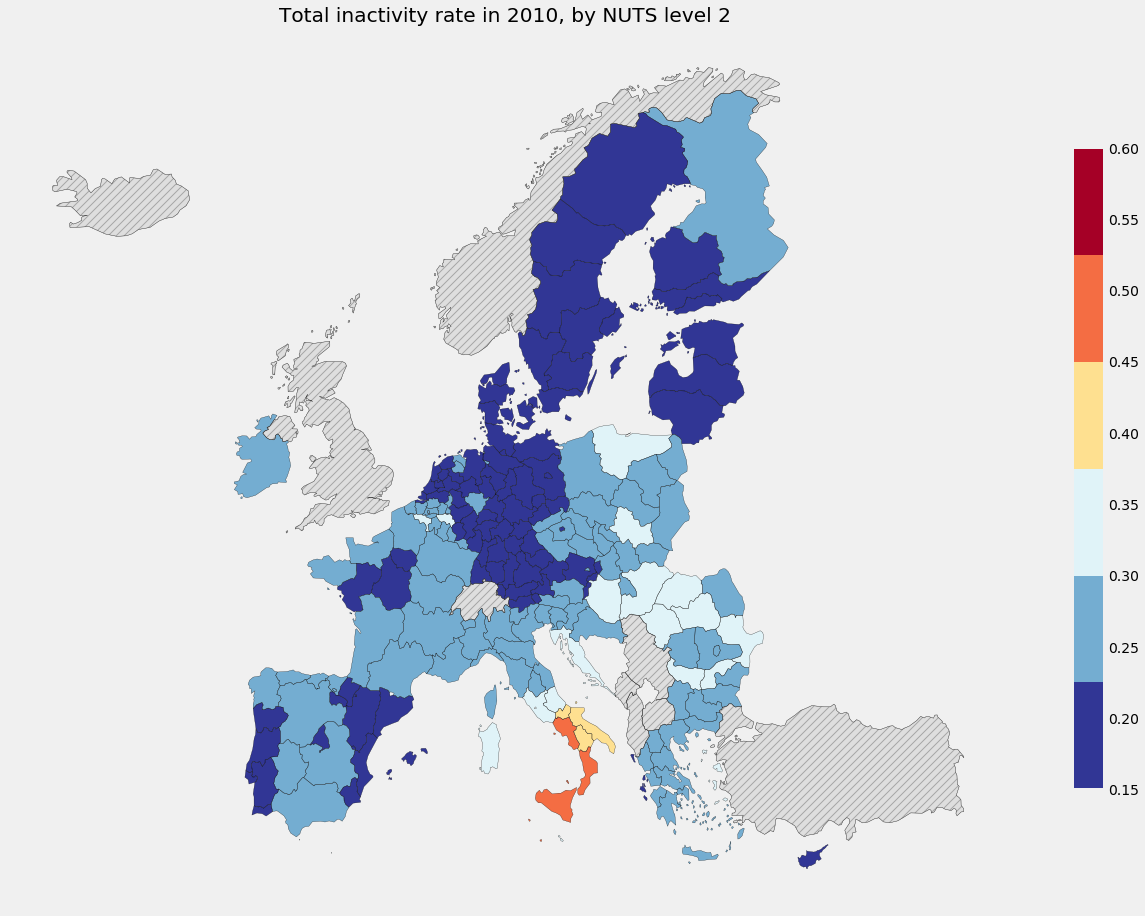

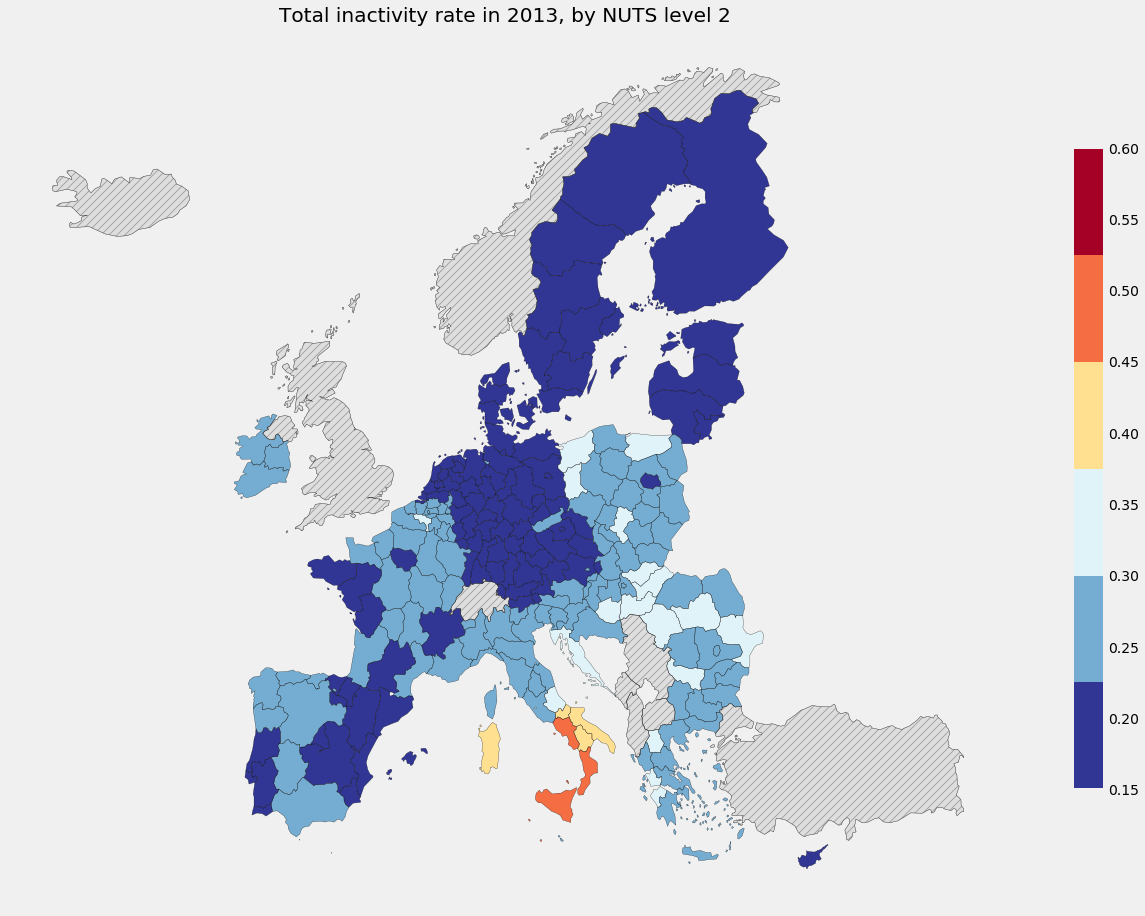

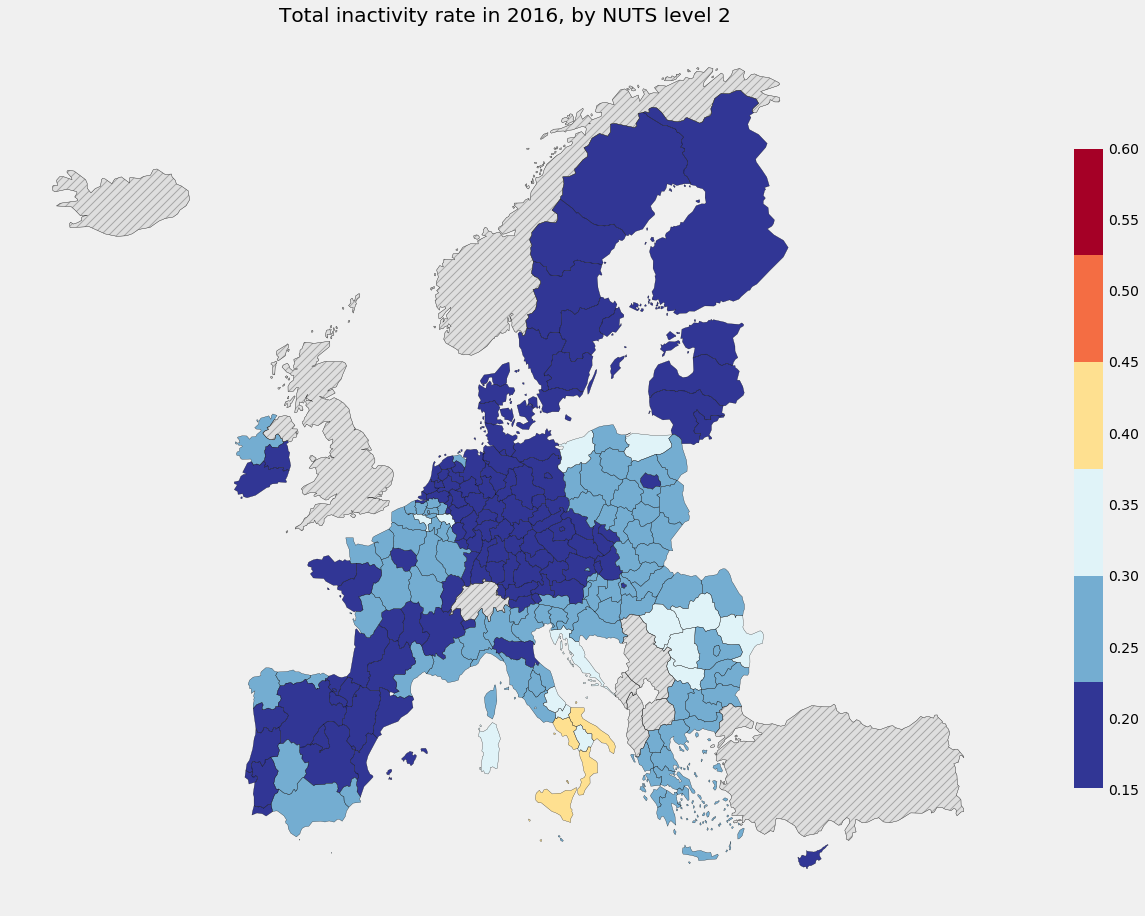

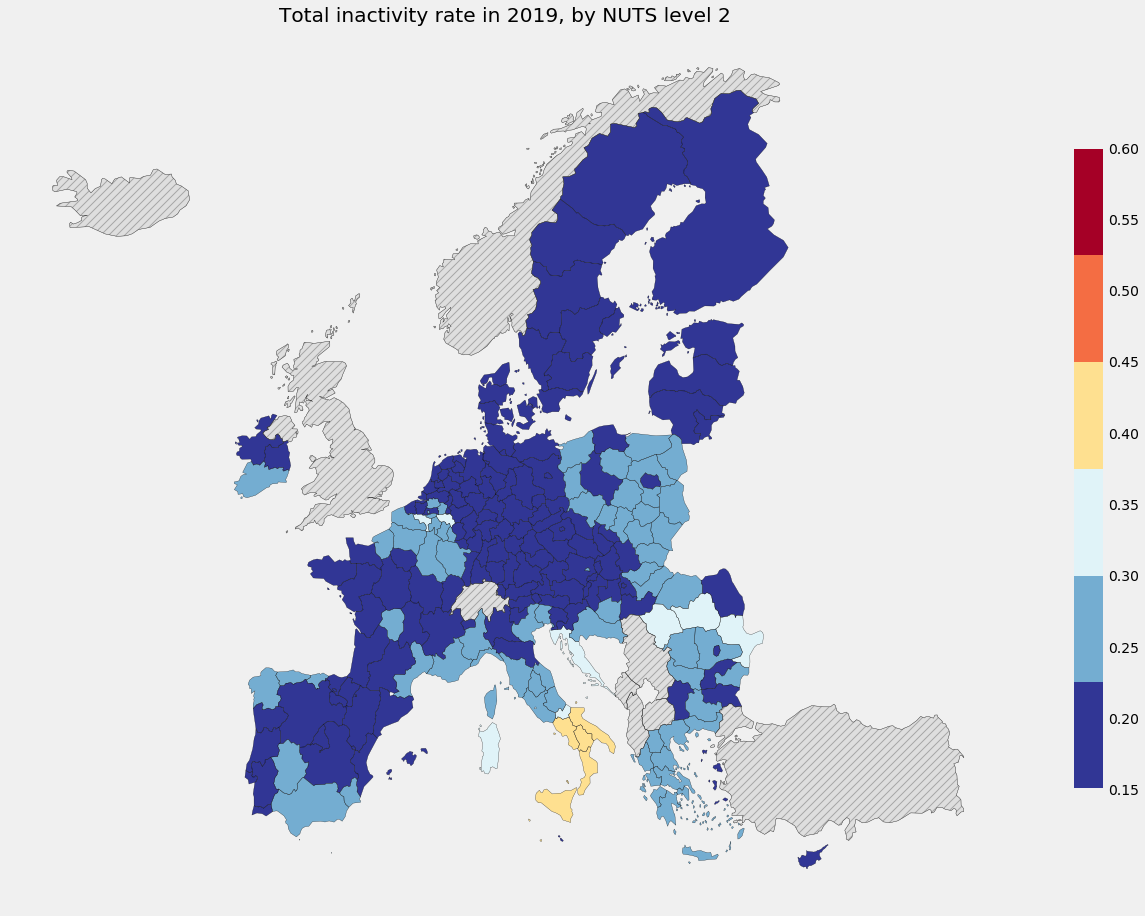

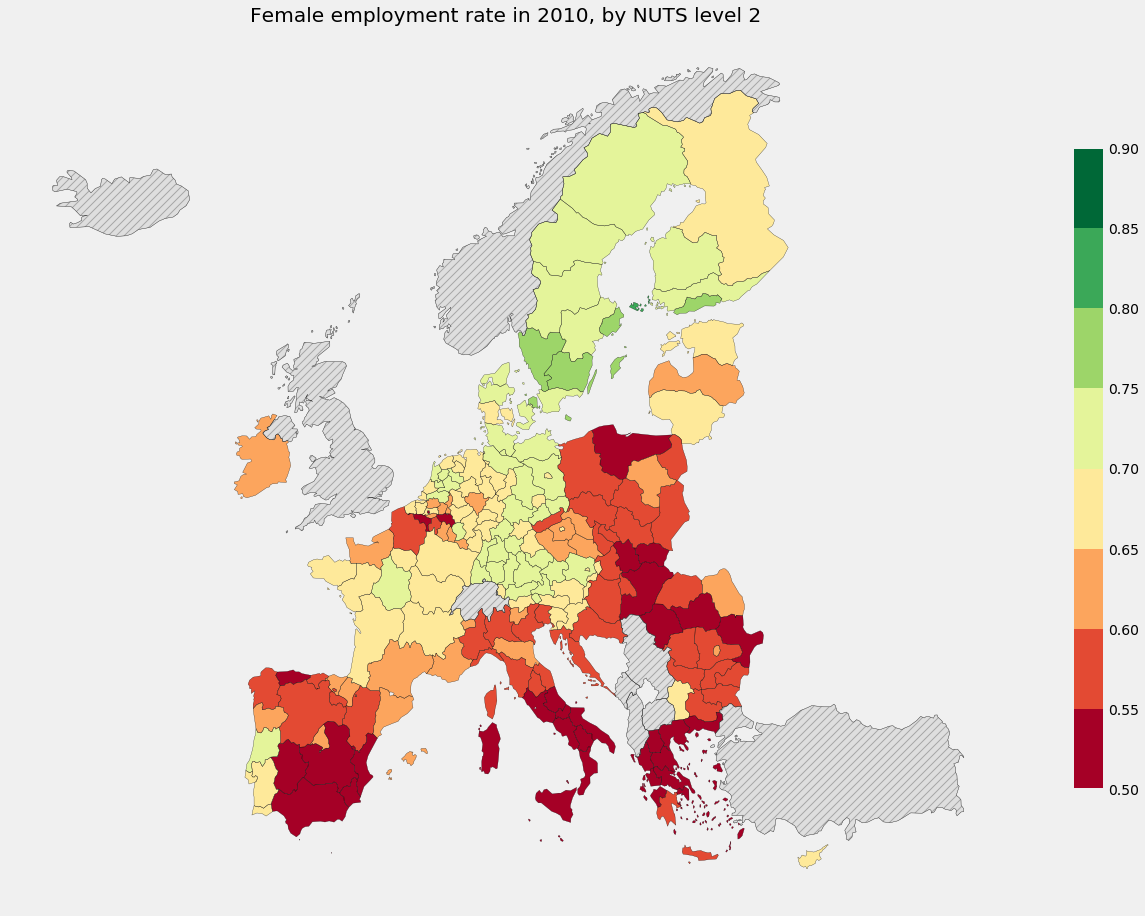

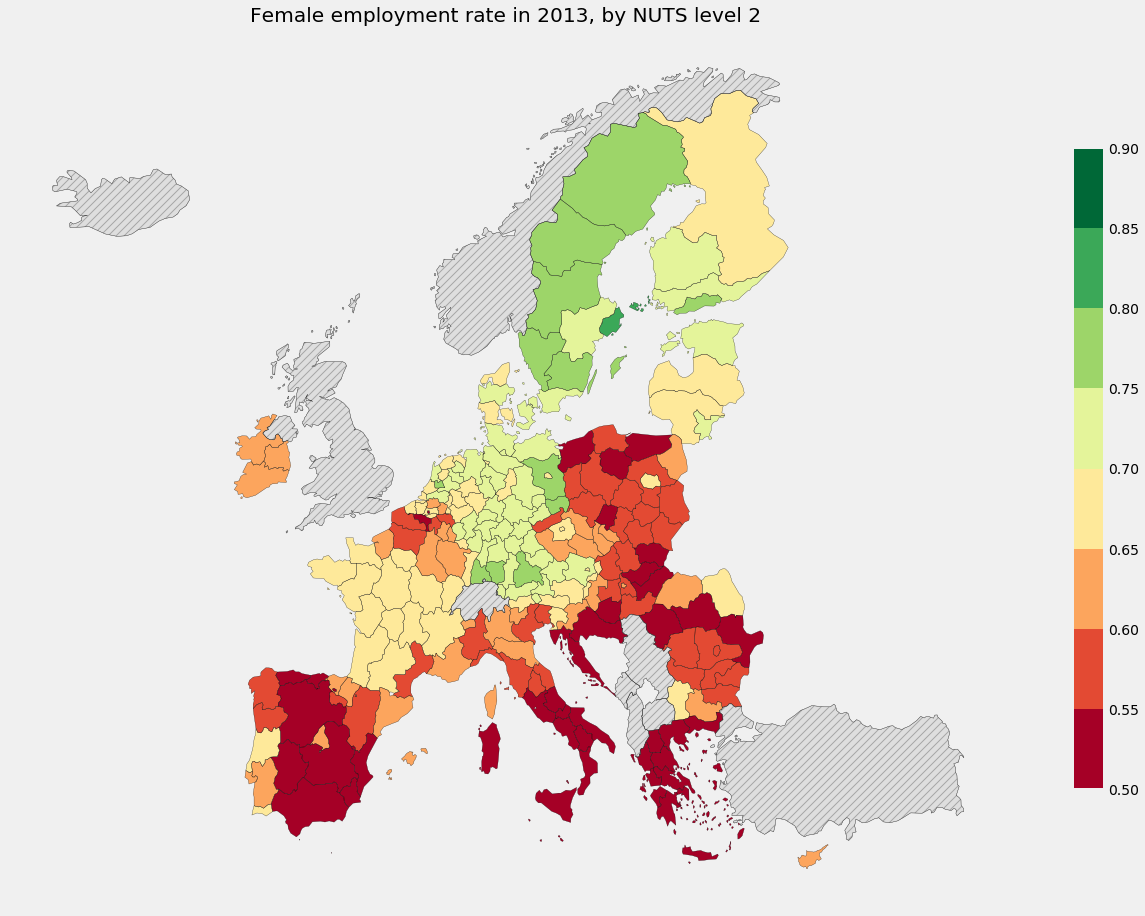

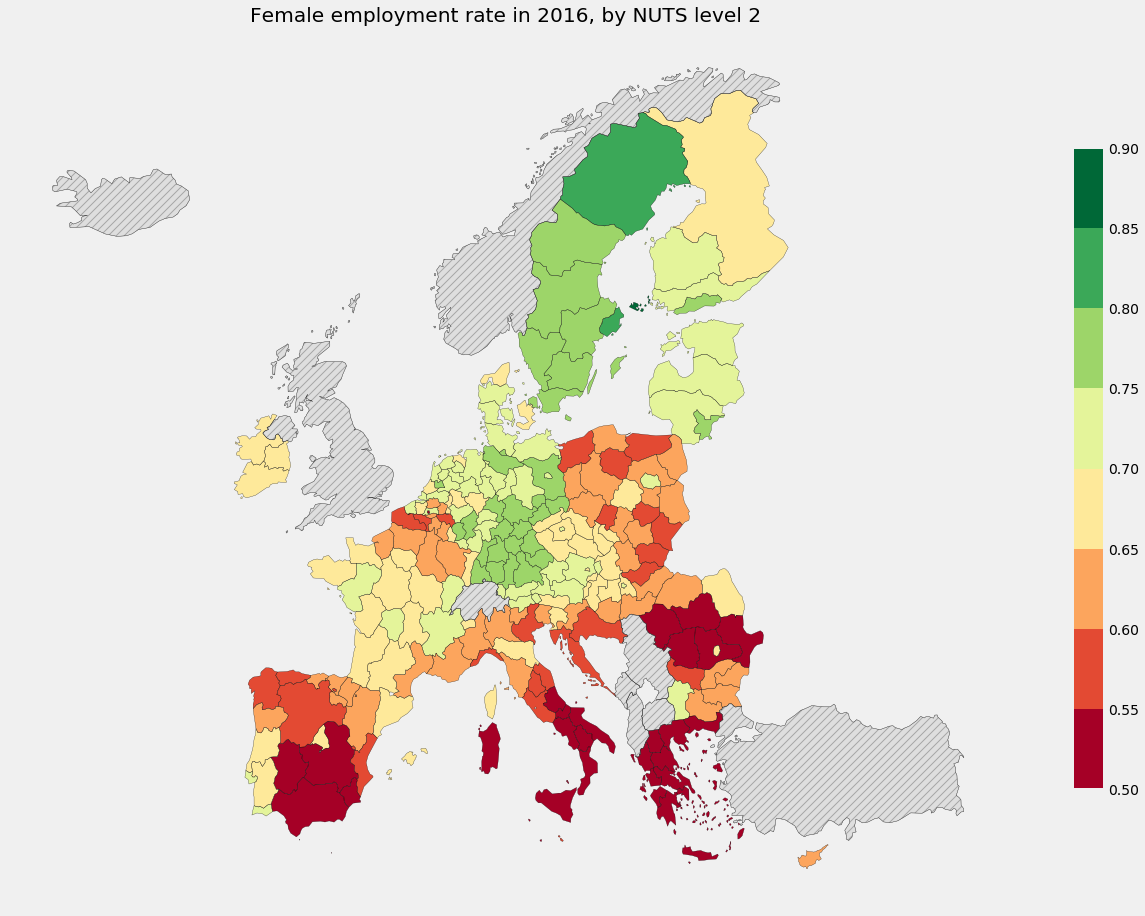

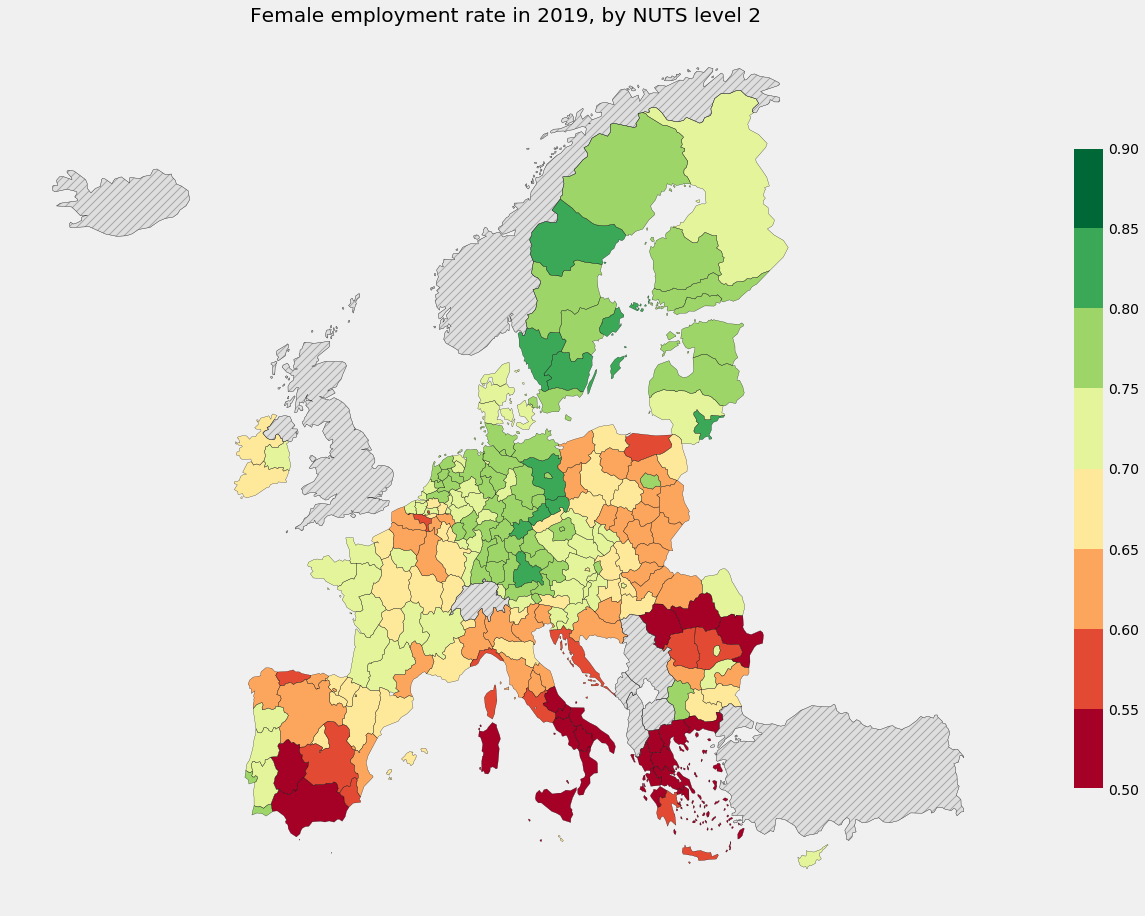

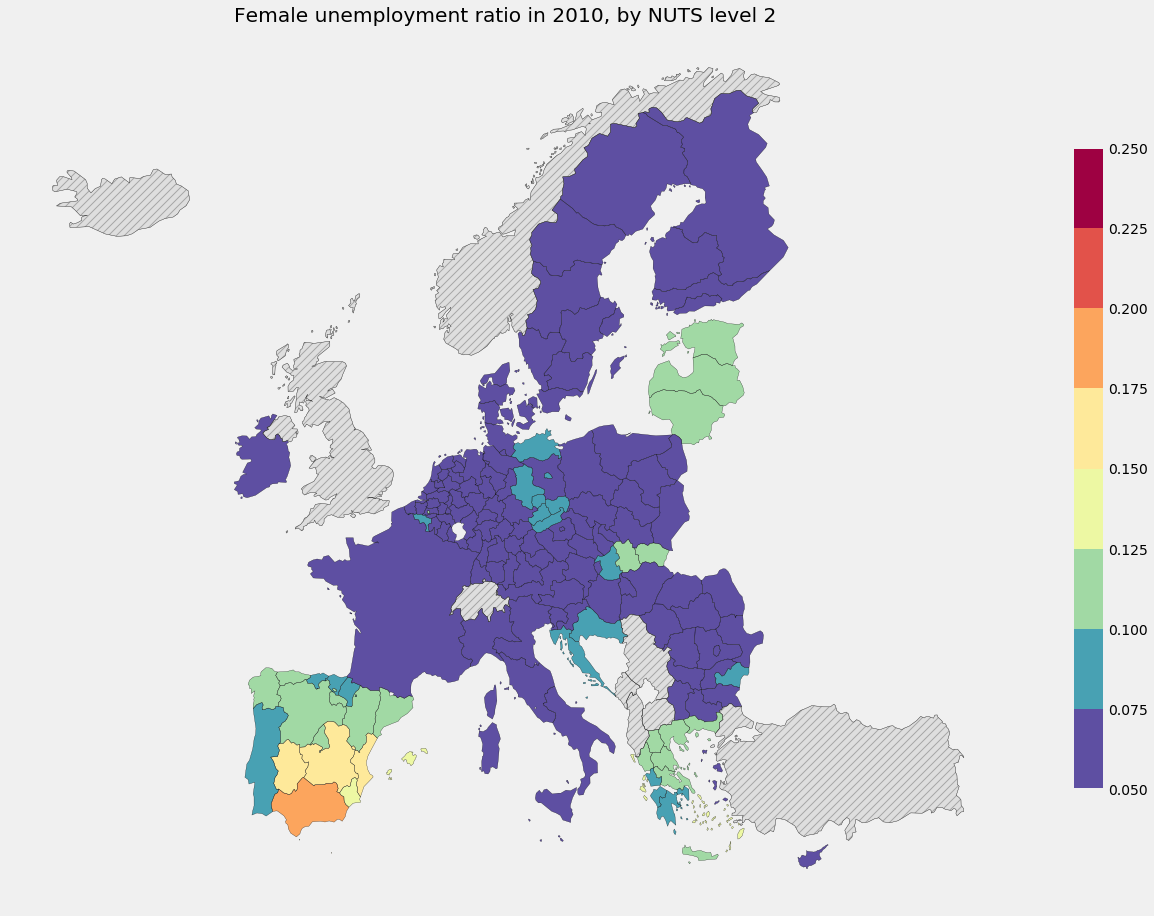

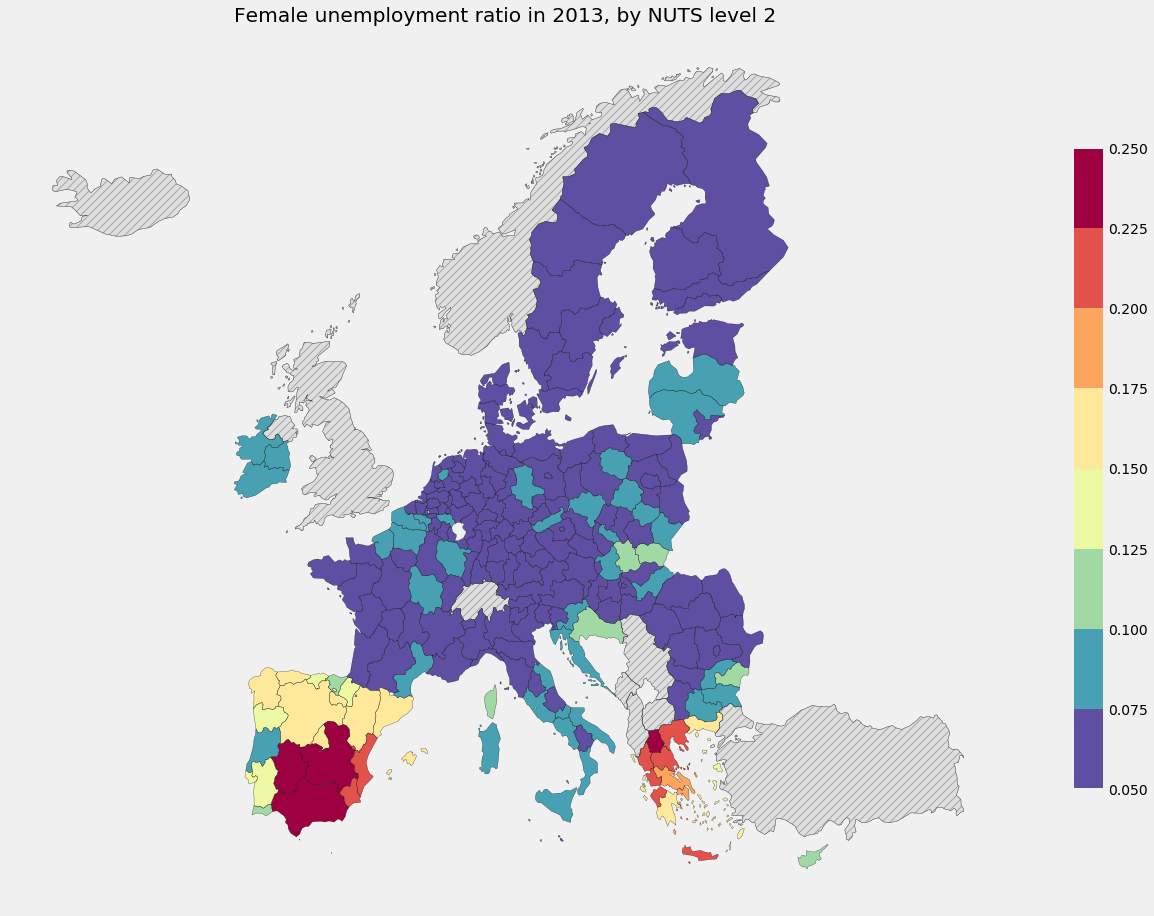

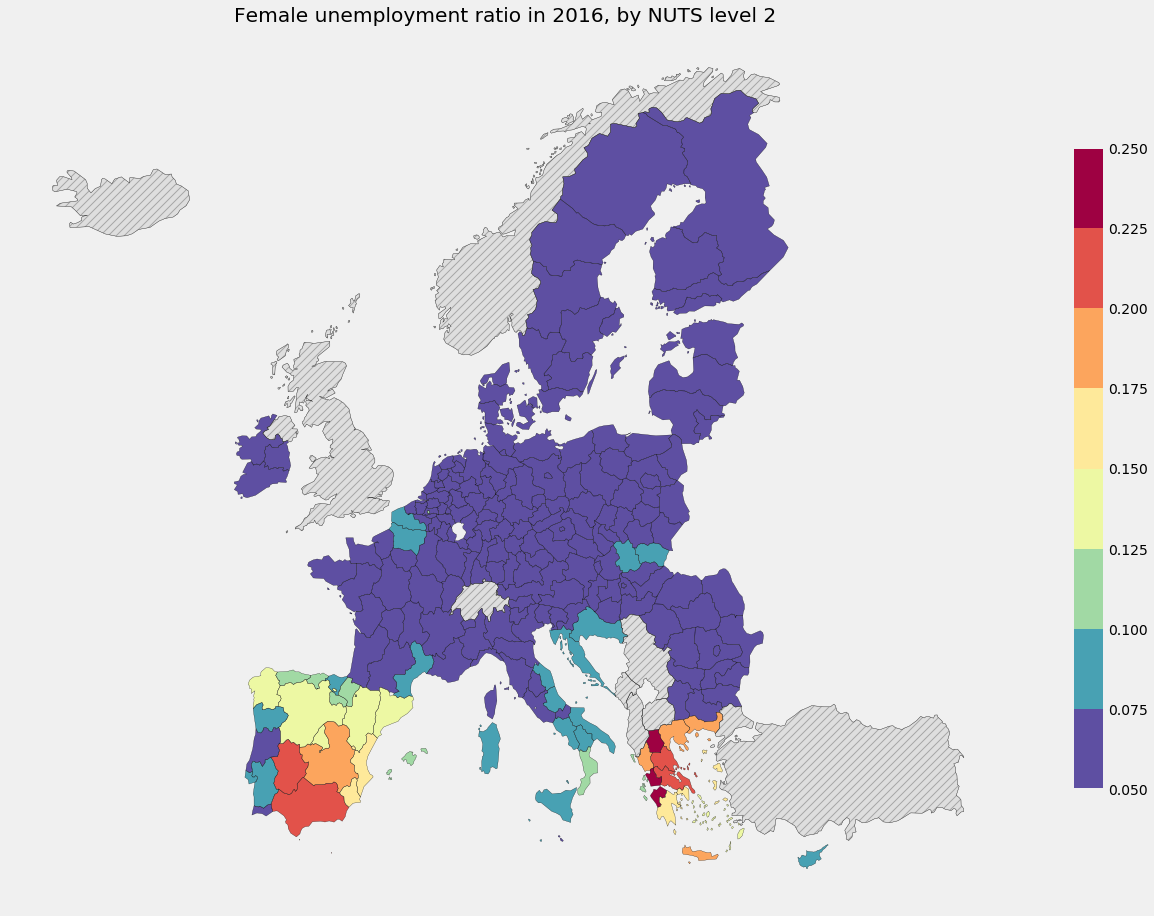

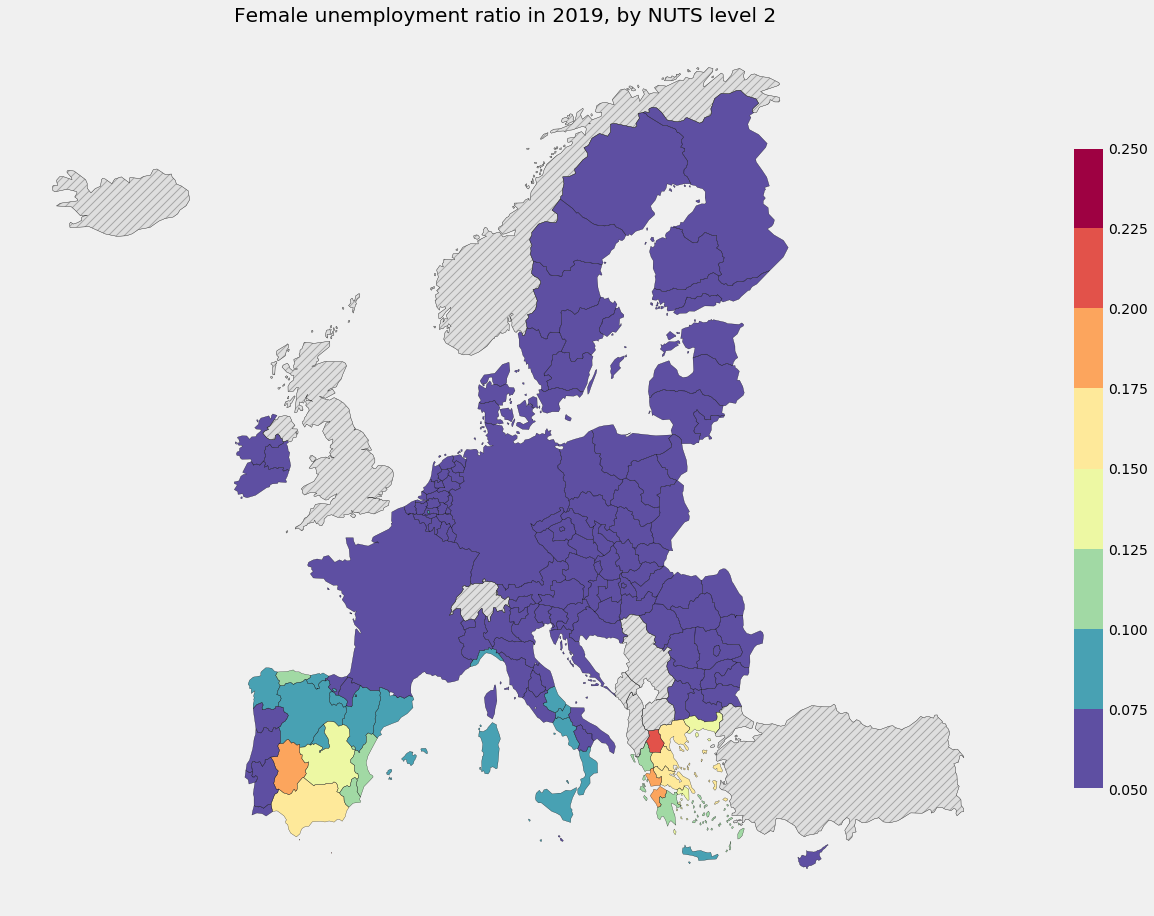

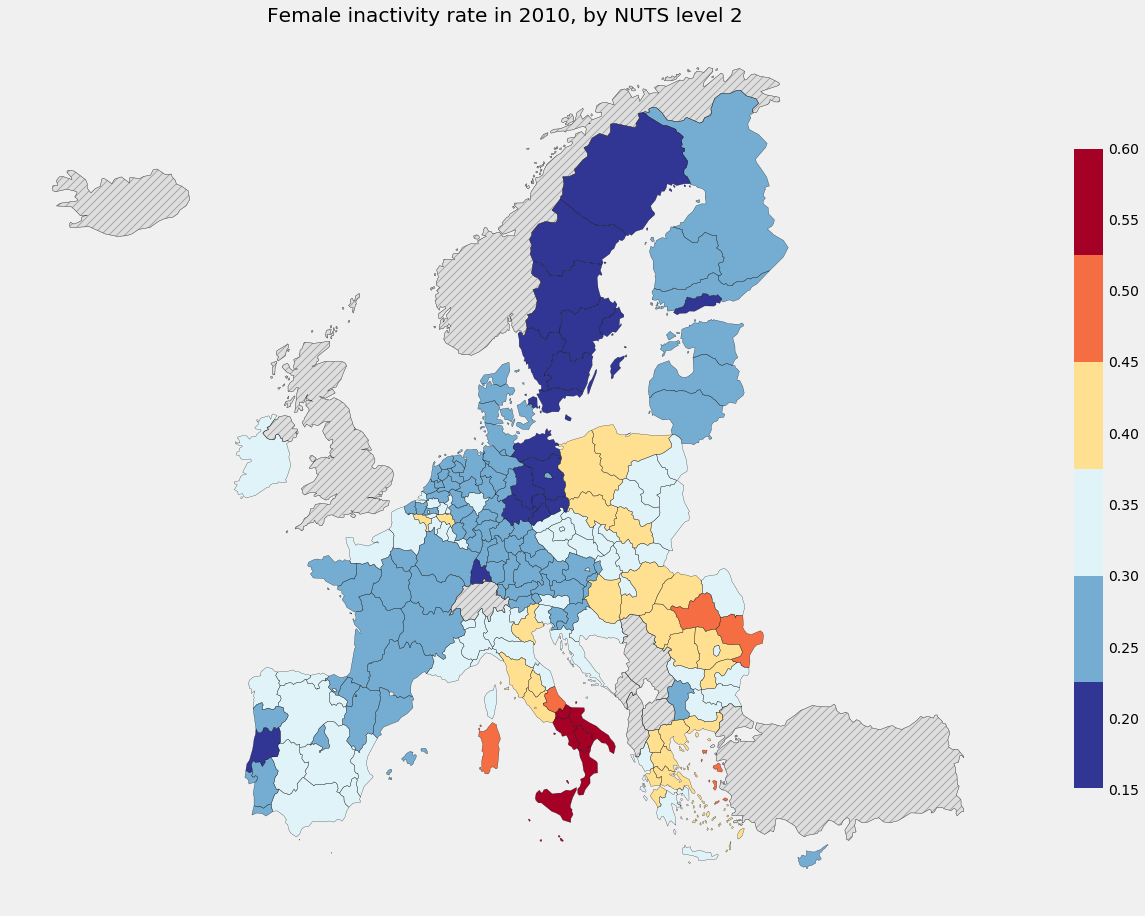

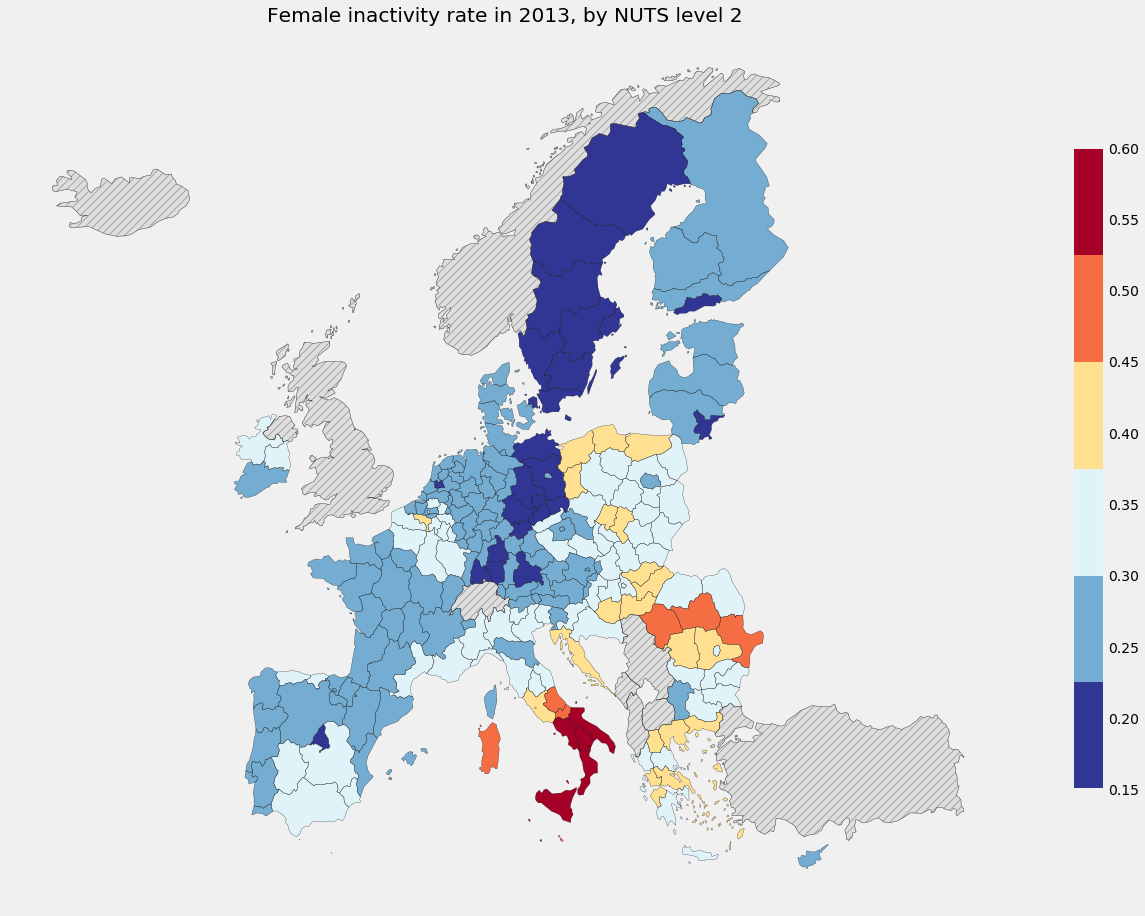

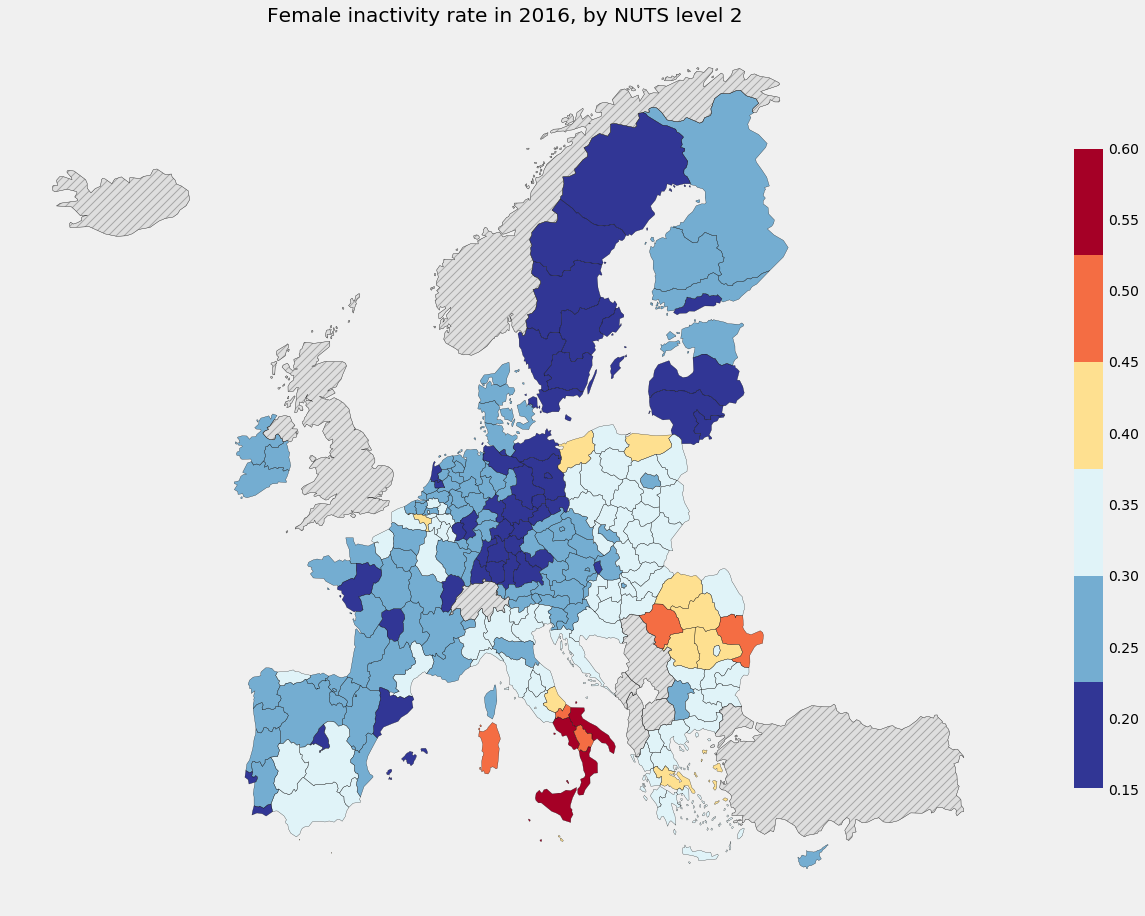

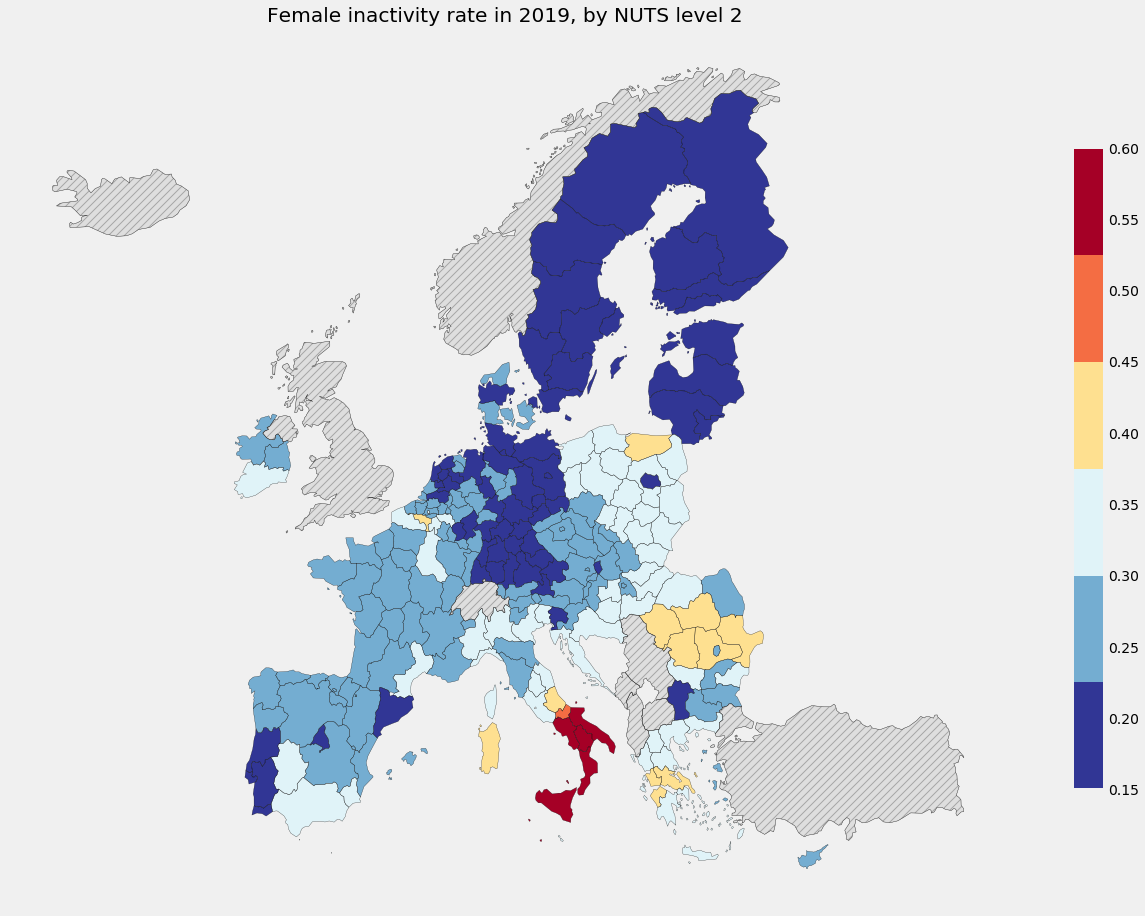

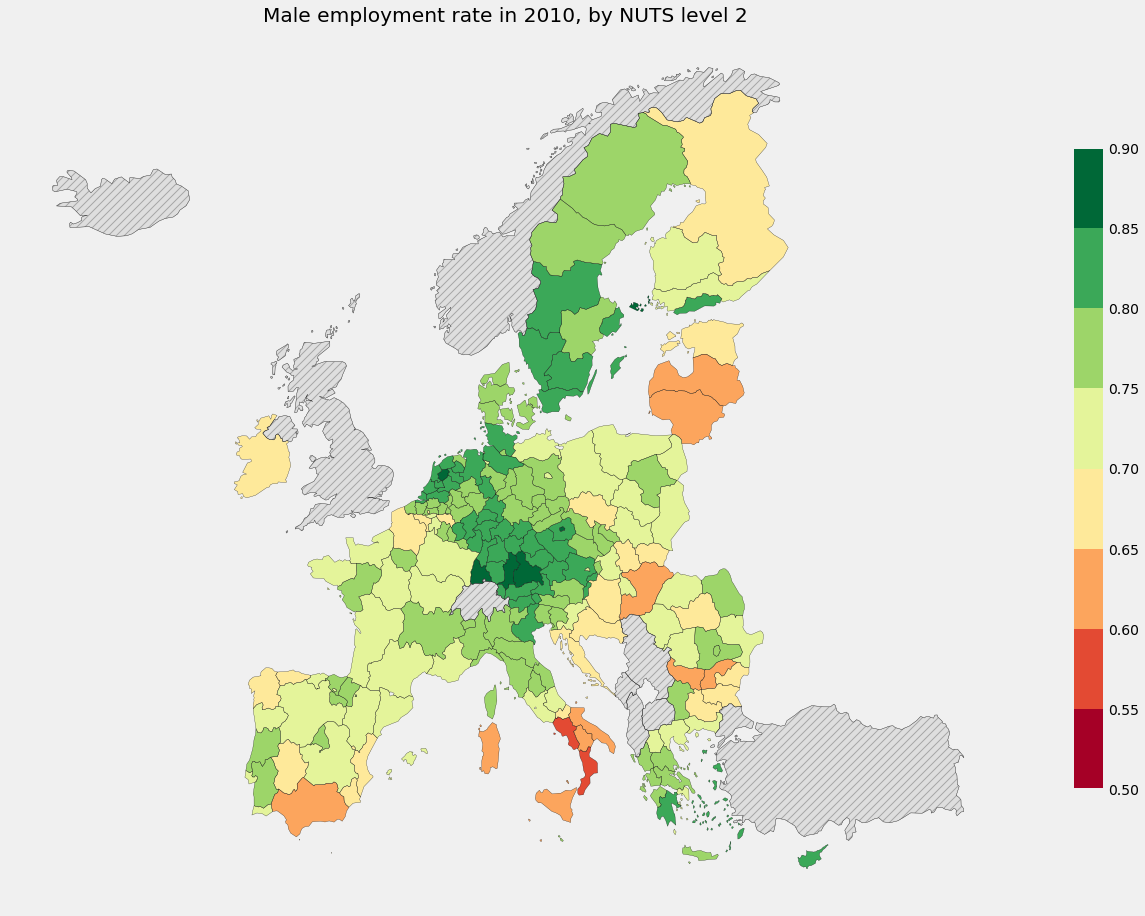

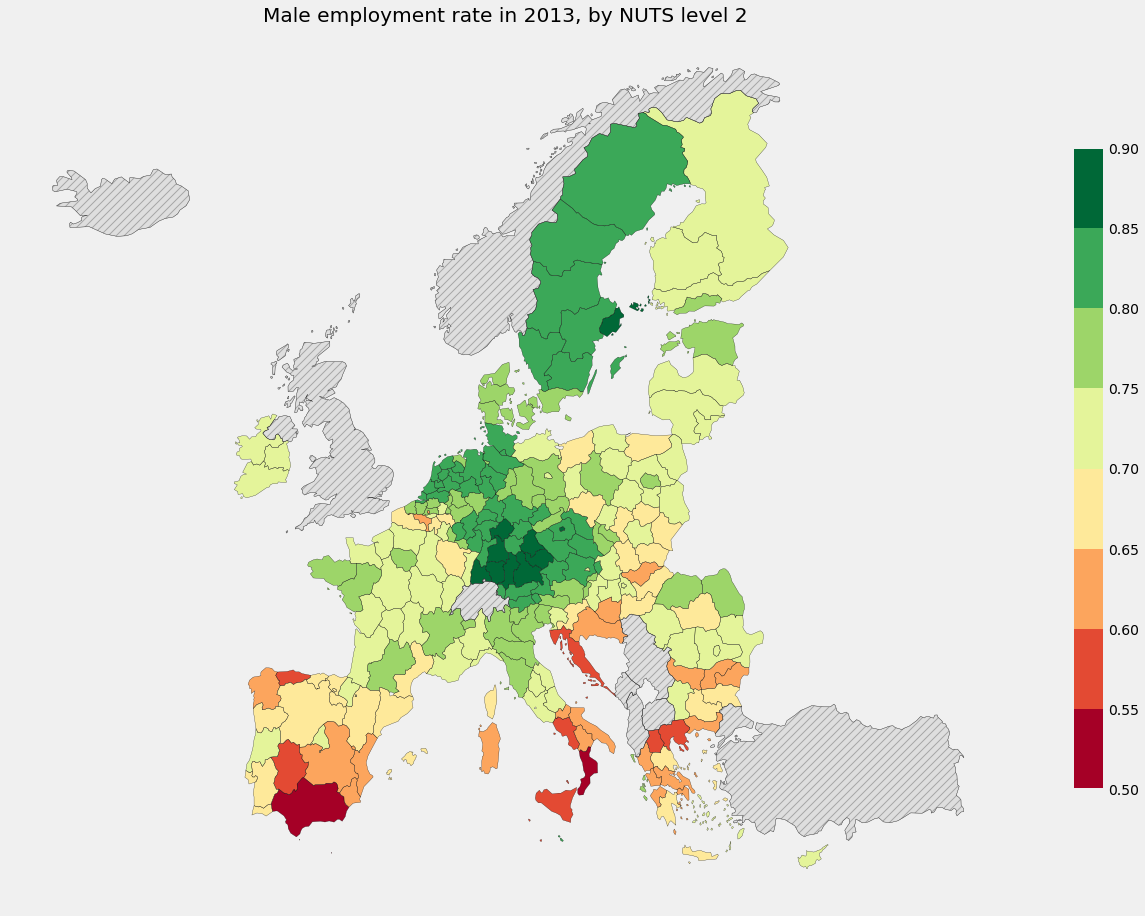

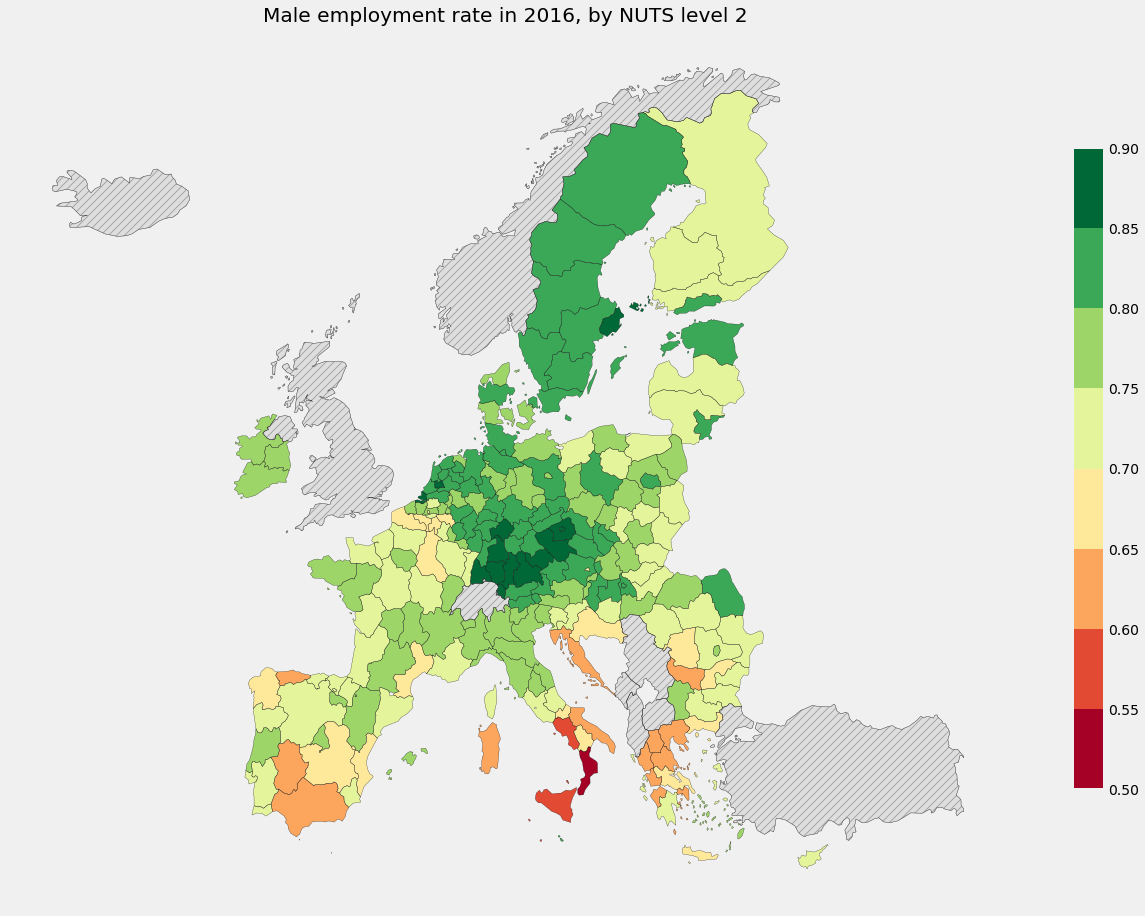

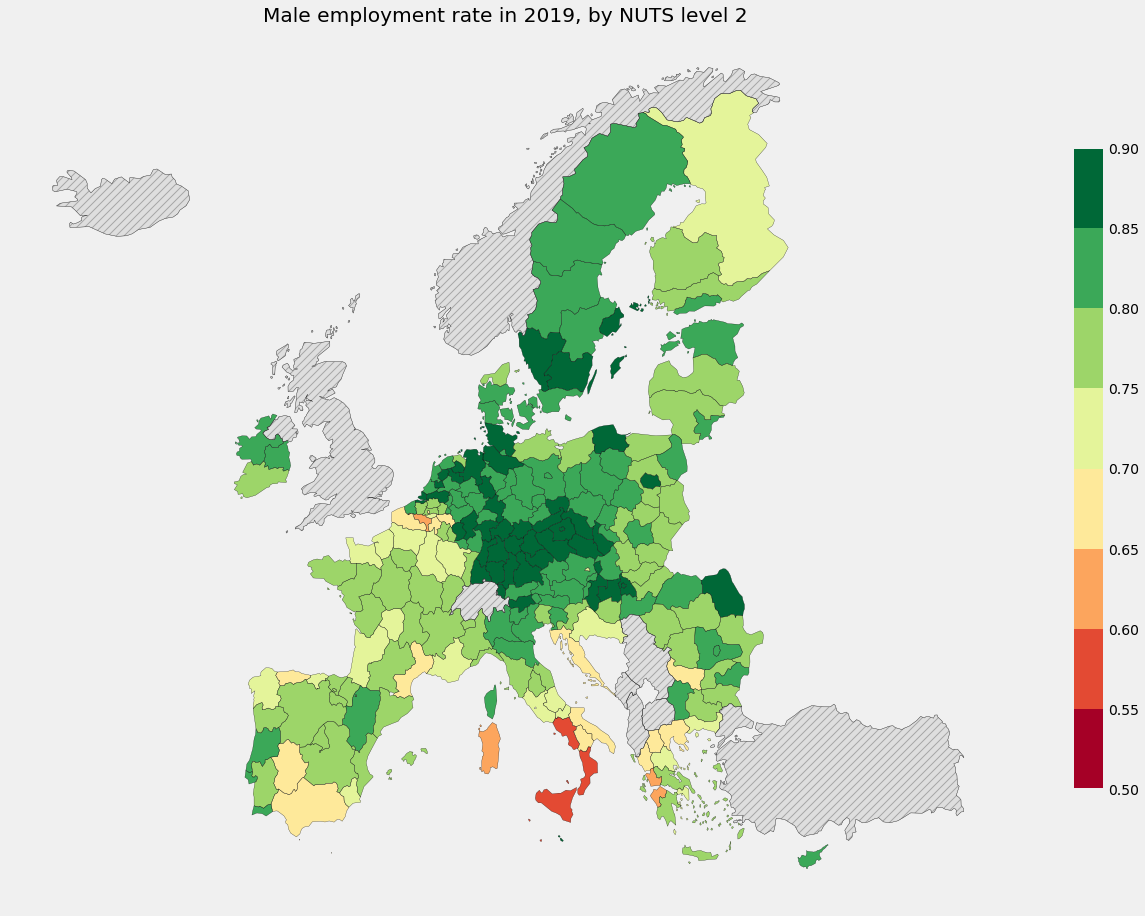

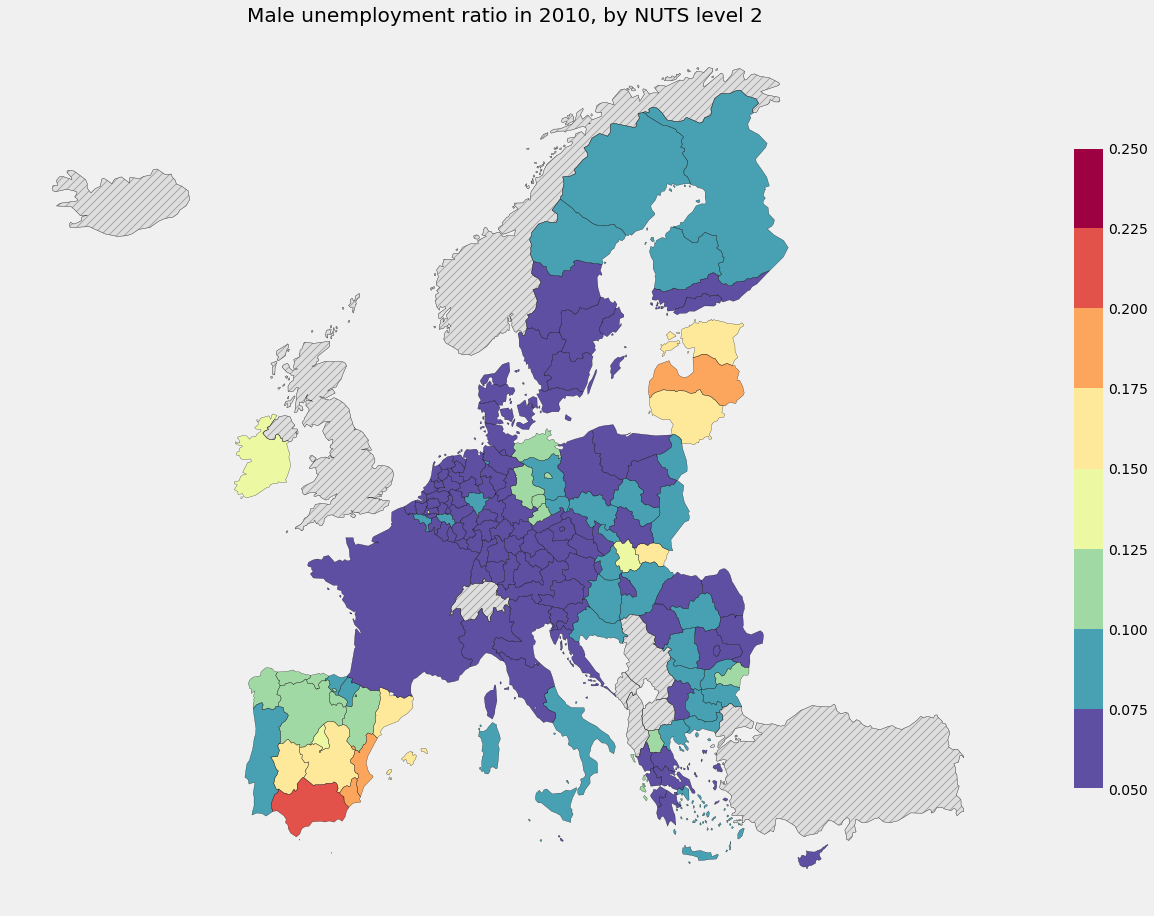

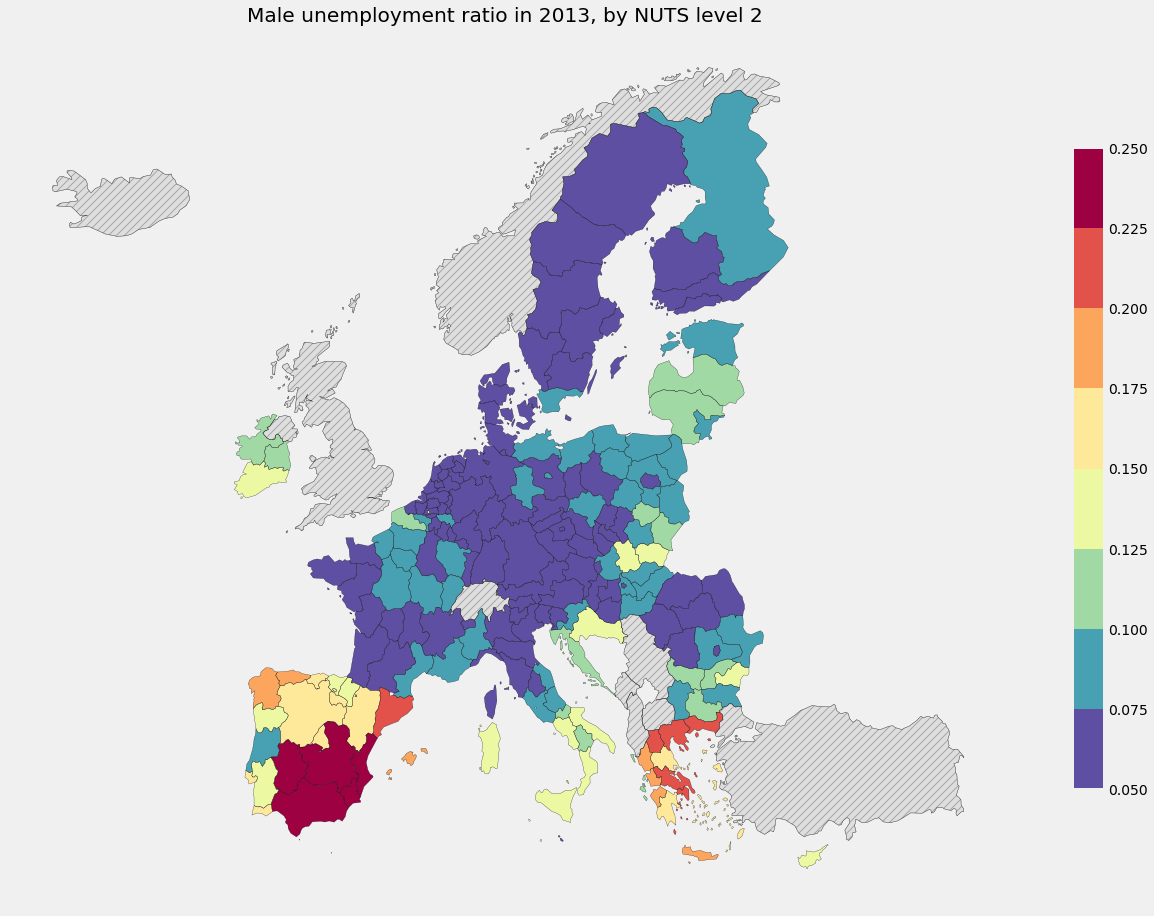

In [ ]:
for s in SEX:
    for w in WSTATUS:
        for y in YEARS:
            temp = build_table(pivo, year = y, key=KEY, 
                            wstatus = w, sex = s, 
                            miss_id=MISSING_CTRY_ID)
            temp = build_unit_level(nuts_data, temp,
                            levels = LEVELS, key = KEY, how='right') 
            data = propagate_unit_level(temp, miss_id = MISSING_CTRY_ID,
                            levels = LEVELS, year = y, key = KEY)
            
            crop = gpd.clip(data[LEVEL], EUclip)
            # crop = nuts_death_data[LEVEL].intersection(EUclip.unary_union) 
            
            f, ax = mplt.subplots(1, figsize=(20, 20))
            crop.plot(column=y, ax=ax, cmap=mpl.cm.get_cmap(colors[w], slices[w]), legend=True, vmax=vmax[w], vmin=vmin[w],
                      legend_kwds = {'shrink':0.55},
                      missing_kwds={ "color": "lightgrey", "alpha": 0.6, "edgecolor": "grey", "hatch": "///"}
                     )
            crop.boundary.plot(ax = ax, color = 'black', linewidth=0.25)
            ax.set_axis_off()
            ax.set_title('%s %s in %s, by NUTS level %s '
                         % (gender[s], status[w], y, LEVEL))
            #f.tight_layout()
            #f.subplots_adjust(hspace=0,wspace=-1)
            mplt.show()
            
# I need to change the name of the map via dictionary

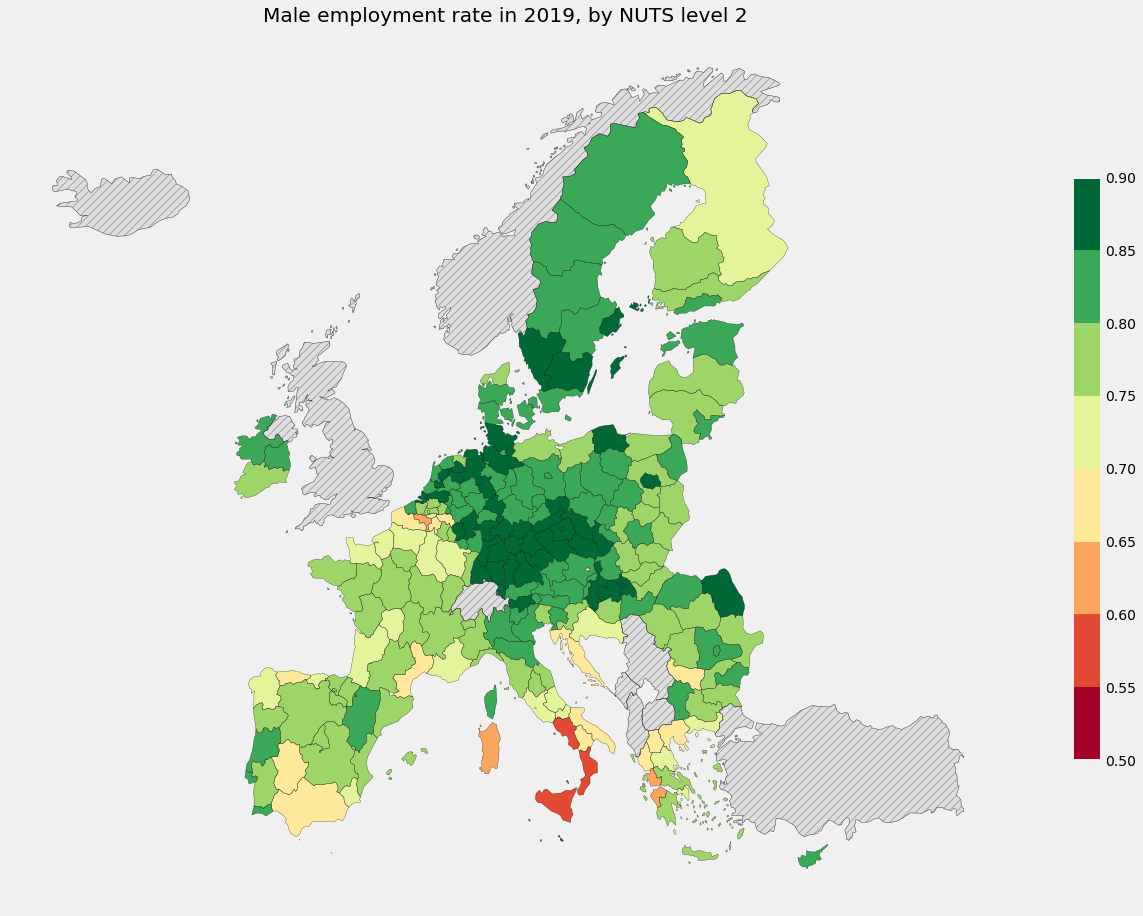

In [39]:
s = SEX[2]
w = WSTATUS[0]
y = YEARS[3]
LEVEL = 2

temp = build_table(pivo, year = y, key=KEY, 
                            wstatus = w, sex = s, 
                            miss_id=MISSING_CTRY_ID)
temp = build_unit_level(nuts_data, temp,
                            levels = LEVELS, key = KEY, how='right') 
data = propagate_unit_level(temp, miss_id = MISSING_CTRY_ID,
                            levels = LEVELS, year = y, key = KEY)


crop = gpd.clip(data[LEVEL], EUclip)
# crop = nuts_death_data[LEVEL].intersection(EUclip.unary_union) 

fig, ax = mplt.subplots(1, figsize=(20, 20))
crop.plot(column=y, ax=ax, cmap=mpl.cm.get_cmap(colors[w], slices[w]), legend=True, vmax=vmax[w], vmin=vmin[w],
          legend_kwds = {'shrink':0.5},
          missing_kwds= { "color": "lightgrey", "alpha": 0.6, "edgecolor": "grey", "hatch": "///"}
         )
crop.boundary.plot(ax = ax, color = 'black', linewidth=0.25)
ax.set_axis_off()
ax.set_title('%s %s in %s, by NUTS level %s '
             % (gender[s], status[w], y, LEVEL))
#fig.tight_layout()
#fig.subplots_adjust(hspace=0,wspace=-1)


mplt.show()

In [40]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autoawait  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %conda  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%markdown  %%perl  %%prun  %%pypy  %%